In [1]:
import sys

import csv
import numpy as np
from tqdm import tqdm_notebook as tqdm

collect all item ids that appear in the dataset (train, test, item_metadata)

In [2]:
item_ids = set()
with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        item_ids.add(int(line[0]))
        
with open('../Dataset/train.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        if line[4] in ['clickout item', 'interaction item deals', 'interaction item image', 'interaction item info',  'interaction item rating',  'search for item'] and line[5].isdigit():
            item_ids.add(int(line[5]))
        if line[10] != '':
            item_ids.update(set(list(map(int, line[10].split('|')))))
            
with open('../Dataset/test.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        if line[4] in ['clickout item', 'interaction item deals', 'interaction item image', 'interaction item info',  'interaction item rating',  'search for item']  and line[5].isdigit():
            item_ids.add(int(line[5]))
        if line[10] != '':
            item_ids.update(set(list(map(int, line[10].split('|')))))

In [3]:
print(f"{len(item_ids)} many items")

928080 many items


Collect all the properties of items, and map them to integer indexes

In [4]:
property_to_index = {}
with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    index = 0
    for line in tqdm(reader):
        for prop in line[1].split('|'):
            if prop not in property_to_index:
                property_to_index[prop] = index
                index += 1

In [5]:
property_to_index

{'Satellite TV': 0,
 'Golf Course': 1,
 'Airport Shuttle': 2,
 'Cosmetic Mirror': 3,
 'Safe (Hotel)': 4,
 'Telephone': 5,
 'Hotel': 6,
 'Sitting Area (Rooms)': 7,
 'Reception (24/7)': 8,
 'Air Conditioning': 9,
 'Hypoallergenic Rooms': 10,
 'Cable TV': 11,
 'Hotel Bar': 12,
 'Pool Table': 13,
 'Bathtub': 14,
 'Satisfactory Rating': 15,
 'Room Service': 16,
 'Luxury Hotel': 17,
 'Terrace (Hotel)': 18,
 'Television': 19,
 'Minigolf': 20,
 'Business Hotel': 21,
 'Shower': 22,
 'Cot': 23,
 'Gym': 24,
 'Hairdryer': 25,
 'Hypoallergenic Bedding': 26,
 'Accessible Parking': 27,
 'From 3 Stars': 28,
 'Good Rating': 29,
 'Radio': 30,
 '4 Star': 31,
 'From 4 Stars': 32,
 'Family Friendly': 33,
 'Desk': 34,
 'Tennis Court (Indoor)': 35,
 'Balcony': 36,
 'WiFi (Public Areas)': 37,
 'Openable Windows': 38,
 'Express Check-In / Check-Out': 39,
 'Restaurant': 40,
 'Laundry Service': 41,
 'Ironing Board': 42,
 'Tennis Court': 43,
 'From 2 Stars': 44,
 'Business Centre': 45,
 'Bowling': 46,
 'Conferenc

In [6]:
len(property_to_index)

157

Map items to property lists (np array), each of length 157 (1 if the property exists, else 0)  
This is itself the item's embedding, later concatenated with its price.

In [7]:
item_to_property = {}

for item in item_ids:
    item_to_property[item] = np.zeros(157)

with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in reader:
        for prop in line[1].split('|'):
            item_to_property[int(line[0])][property_to_index[prop]] = 1

In [8]:
item_to_property[5111]

array([1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [9]:
len(item_to_property)

928080

Map other non-integer properties to integers

In [10]:
user = set()
action_type = set()
platform = set()
city = set()
device = set()
current_filters = set()

In [11]:
with open('../Dataset/train.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        user.add(line[0])
        action_type.add(line[4])
        platform.add(line[6])
        city.add(line[7])
        device.add(line[8])
        if line[9]:
            for filter in line[9].split('|'):
                current_filters.add(filter)
            
with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        user.add(line[0])
        action_type.add(line[4])
        platform.add(line[6])
        city.add(line[7])
        device.add(line[8])
        if line[9]:
            for filter in line[9].split('|'):
                current_filters.add(filter)

In [12]:
user = sorted(list(user))
action_type = sorted(list(action_type))
platform = sorted(list(platform))
city = sorted(list(city))
device = sorted(list(device))
current_filters = sorted(list(current_filters))

In [13]:
print(len(user))
print(len(action_type))
print(len(platform))
print(len(city))
print(len(device))
print(len(current_filters))

948041
10
55
37843
3
205


In [14]:
user_to_ind = {user[i]:i for i in range(len(user))}
action_to_ind = {action_type[i]:i for i in range(len(action_type))}
platform_to_ind = {platform[i]:i for i in range(len(platform))}
city_to_ind = {city[i]:i for i in range(len(city))}
device_to_ind = {device[i]:i for i in range(len(device))}
current_filters_to_ind = {current_filters[i]:i for i in range(len(current_filters))}

Mapping reference value to integers, each in separate bins based on their action type

In [15]:
reference = [set() for _ in range(10)]
with open('../Dataset/train.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        reference[action_to_ind[line[4]]].add(line[5])

with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        reference[action_to_ind[line[4]]].add(line[5])

There are noises in the 'interaction item info' action reference value. Should remove them.

In [16]:
for i in range(len(reference)):
    count = 0
    for ref in reference[i]:
        if ref.isdigit():
            count += 1
    print(f"{action_type[i]}: {count}/{len(reference[i])}")

change of sort order: 0/9
clickout item: 309028/309029
filter selection: 0/205
interaction item deals: 94107/94108
interaction item image: 218236/218237
interaction item info: 135661/135667
interaction item rating: 100159/100160
search for destination: 0/25309
search for item: 82565/82566
search for poi: 0/15118


test data contains actions that are missing their reference value

In [17]:
with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    
    count = 0
    for line in reader:
        if line[4]!='clickout item' and line[5]=='':
            print(line)

['1YR377TGKCMP', 'c7c74978873ee', '1541595378', '3', 'interaction item image', '', 'FR', "Villette-d'Anthon, France", 'mobile', '', '', '']
['2G0DG5OGS3W4', '28158eb175d72', '1541602901', '2', 'interaction item image', '', 'US', 'Brussels, Belgium', 'desktop', '', '', '']
['2HCMLGZB027P', '7de60e25abcbe', '1541629524', '4', 'interaction item image', '', 'UK', 'Manchester, United Kingdom', 'mobile', '', '', '']
['2PJ0K44IHE1U', '0a6359c6b6a2f', '1541709698', '8', 'interaction item image', '', 'AU', 'Adelaide, Australia', 'mobile', '', '', '']
['37J48I4D90T9', 'a1c9a969e19ec', '1541698061', '3', 'interaction item image', '', 'IN', 'Pune, India', 'mobile', '', '', '']
['3HKZ9Q2GXF3L', '01c887f2453ff', '1541678651', '8', 'interaction item image', '', 'BR', 'Cancun, Mexico', 'mobile', '', '', '']
['3HKZ9Q2GXF3L', '4aa8cbd62d691', '1541712410', '8', 'interaction item image', '', 'BR', 'Cancun, Mexico', 'mobile', '', '', '']
['3HKZ9Q2GXF3L', '96cff00137b95', '1541615361', '8', 'interaction it

['Z30XQP31FSY2', 'd21162e04b1e5', '1541684157', '26', 'interaction item image', '', 'MY', 'Alor Setar, Malaysia', 'mobile', '', '', '']
['086QQOYDCY2U', 'e99cedbf5c6d3', '1541645486', '14', 'interaction item image', '', 'CO', 'Armenia, Colombia', 'desktop', '', '', '']
['0SBLYVYSB3RI', 'b16dfcd5ad9c4', '1541604187', '106', 'interaction item image', '', 'DE', 'Feldberg, Germany', 'mobile', '', '', '']
['0U34P4NI5HMK', 'd1542510069c4', '1541624751', '3', 'interaction item image', '', 'BR', 'Natal, Brazil', 'mobile', '', '', '']
['2X4CRAE3BHPO', 'ffaafabf3a72f', '1541659018', '3', 'interaction item image', '', 'US', 'Allentown, USA', 'mobile', '', '', '']
['47SIA356BWWT', 'd33efe78ae5cf', '1541589504', '1', 'search for destination', '', 'ES', 'Rome, Italy', 'desktop', '', '', '']
['5VEGHKFFXWK2', '5e970a6820ec3', '1541593932', '4', 'interaction item image', '', 'FR', 'Saint-Lary-Soulan, France', 'mobile', '', '', '']
['65QGY3EOQH9J', 'cacf8c9cb2220', '1541607069', '1', 'search for destina

['5ME8FL2M6W6L', 'ebf2ffc2cc60a', '1541604843', '1', 'interaction item deals', '', 'US', 'Las Vegas, USA', 'mobile', '', '', '']
['5OC6RXIW26HV', '3d8df6a2491a8', '1541675040', '1', 'interaction item image', '', 'HU', 'Toronto, Canada', 'mobile', '', '', '']
['5R9ZZYQ9ZDUK', 'b7c2b6054f9dc', '1541679951', '40', 'interaction item rating', '', 'US', 'Paris, France', 'mobile', '', '', '']
['65XWZS77LB0S', 'b294e9b162665', '1541634334', '11', 'interaction item rating', '', 'BR', 'Belo Horizonte, Brazil', 'mobile', '', '', '']
['71FI7THHDCX7', '9062401e121b1', '1541659605', '9', 'interaction item image', '', 'AU', 'New York, USA', 'desktop', '', '', '']
['8MSJXHH8JZ7W', '6249fd9e9c908', '1541623533', '1', 'interaction item rating', '', 'AR', 'San Clemente del Tuyú, Argentina', 'mobile', '', '', '']
['9DWRZKU278XT', '0988bbd9da3de', '1541604109', '2', 'change of sort order', '', 'FR', 'Marseille, France', 'desktop', '', '', '']
['9OKGIEXPIKWK', 'ced2ca3ae37ab', '1541680563', '5', 'interactio

['EWUORQMBKWHU', 'd80cf6410cf3a', '1541664614', '1', 'interaction item info', '', 'JP', 'Singapore, Singapore', 'mobile', '', '', '']
['JMJEFDSUG0JQ', '79af5289bd72e', '1541582093', '13', 'interaction item image', '', 'RU', 'Perm, Russia', 'mobile', '', '', '']
['KM7WDTC03BJ3', 'sr0atnvsbcqki', '1541679213', '3', 'change of sort order', '', 'DE', 'Bad Oeynhausen, Germany', 'desktop', '', '', '']
['N1NVNLRM1Y2R', '98829dda92cc1', '1541683189', '30', 'interaction item image', '', 'US', 'Bogotá, Colombia', 'mobile', '', '', '']
['P9VTWLHH71FW', 'a21e22c864ff3', '1541599352', '1', 'interaction item image', '', 'PH', 'Nusa Dua, Indonesia', 'mobile', '', '', '']
['Q806W1XDYJG1', '1987d4991295a', '1541674931', '4', 'interaction item deals', '', 'AU', 'Traralgon, Australia', 'mobile', '', '', '']
['QCJY0F53MNYU', '246b91aa5dc7c', '1541581976', '1', 'search for poi', '', 'GR', 'Prague, Czech Republic', 'mobile', '', '', '']
['R3LBSYPXFY9B', '2418565cf943f', '1541642167', '95', 'interaction item

['0PH4RHOIIA53', '10f49f72ed595', '1541706643', '1', 'interaction item image', '', 'MX', 'San Cristobal de las Casas, Mexico', 'desktop', '', '', '']
['2FBGVPZ68017', '3886afae673ac', '1541611220', '1', 'interaction item image', '', 'IL', 'Amsterdam, Netherlands', 'mobile', '', '', '']
['2MGHR5KPZFDI', 'ca812da25439f', '1541592686', '1', 'change of sort order', '', 'DE', 'Stuttgart, Germany', 'desktop', '', '', '']
['2S452G0X5F75', '2828b330da09d', '1541619342', '5', 'interaction item image', '', 'ES', 'Brussels, Belgium', 'mobile', '', '', '']
['38P9GG5RU6Z2', '6fff2d2557be0', '1541582252', '5', 'interaction item image', '', 'JP', 'Kagoshima, Japan', 'mobile', '', '', '']
['39YCY5SUDGDI', '84b6e31b05c24', '1541692897', '3', 'interaction item image', '', 'MX', 'Ecatepec de Morelos, Mexico', 'desktop', '', '', '']
['3ZIYS3AZMODD', 'b80f209aadef8', '1541679354', '7', 'change of sort order', '', 'IT', 'Berlin, Germany', 'desktop', '', '', '']
['41WPSD7L47BW', '84310ae8ecbd8', '1541667950'

['NA1G2ZOS93VJ', 'cc31f11fd57ea', '1541633164', '1', 'interaction item image', '', 'BR', 'São Bento do Sapucaí, Brazil', 'mobile', '', '', '']
['NS0FQ70MWD20', '15ce78cf5318b', '1541607577', '4', 'interaction item image', '', 'US', 'Renton, USA', 'mobile', '', '', '']
['OOR3S100B38F', '02c4daf8b0ed7', '1541634430', '4', 'interaction item image', '', 'BR', 'Ilha Comprida, Brazil', 'mobile', '', '', '']
['S5FJHMT9FXN3', '8514619ffc7c1', '1541715752', '4', 'search for destination', '', 'UK', 'Miami Beach, USA', 'tablet', 'Sort by Price', '', '']
['TI4TR4U4AE8L', 'b631641782833', '1541719358', '6', 'interaction item info', '', 'DE', 'Munich, Germany', 'mobile', '', '', '']
['TQRD959P494H', '6f7840ee8f9f4', '1541619526', '21', 'interaction item image', '', 'HU', 'Badacsonytomaj, Hungary', 'desktop', '', '', '']
['UFZ19SJ1QBIJ', '70cad78a50afd', '1541622456', '1', 'search for item', '', 'AR', 'San Juan City, Argentina', 'mobile', '', '', '']
['UVGDQI6U71RX', '9a7b4536d22cd', '1541685562', '3

['X6Z6U8QY7MWY', 'd34c05a37d24b', '1541696126', '1', 'interaction item image', '', 'ES', 'Castellón de la Plana, Spain', 'mobile', '', '', '']
['YGN1332W29ZC', '87521de5ec2a1', '1541607362', '7', 'interaction item image', '', 'RU', 'Istanbul, Turkey', 'desktop', '', '', '']
['YMMEQ32P3S0L', '5c334f8a219b9', '1541590012', '1', 'interaction item image', '', 'RU', 'Khabarovsk, Russia', 'mobile', '', '', '']
['Z8YWVDJKQ1V5', 'ea7f487701c54', '1541593258', '1', 'search for destination', '', 'PE', 'Ica, Peru', 'mobile', '', '', '']
['ZSU9HTCHR99K', '7a17363a59bcd', '1541721320', '4', 'search for destination', '', 'IE', 'Albufeira, Portugal', 'tablet', '', '', '']
['1GXIYEU14033', '3a30cb66d6c5d', '1541700561', '2', 'interaction item image', '', 'US', 'Philadelphia, USA', 'tablet', '', '', '']
['1GXIYEU14033', '5bb7486f50a00', '1541706890', '2', 'interaction item image', '', 'US', 'Philadelphia, USA', 'tablet', '', '', '']
['1I388W25E9SQ', '6af46329b0f1a', '1541611767', '2', 'interaction item

['X7WHCA753RM2', '4bf33ff10459c', '1541701832', '1', 'interaction item image', '', 'NL', 'Antwerp, Belgium', 'desktop', '', '', '']
['XNLC79O30BP5', '693ec9e9349e8', '1541623092', '4', 'filter selection', '', 'MX', 'Havana, Cuba', 'desktop', '5 Star|4 Star|3 Star|2 Star|Hotel|Motel|Resort|Hostal (ES)', '', '']
['XNLC79O30BP5', '83667533672d7', '1541614803', '4', 'interaction item info', '', 'MX', 'San Juan de los Lagos, Mexico', 'desktop', '', '', '']
['Y74CHL1F5N4W', 'e97584bbeb958', '1541648791', '4', 'interaction item info', '', 'BR', 'Florianópolis, Brazil', 'mobile', '', '', '']
['0FOERHSOU51G', 'cab0f99548cc0', '1541690243', '7', 'interaction item image', '', 'GR', 'Agios Lavrentios, Greece', 'mobile', '', '', '']
['1RF9CB6FIKIQ', 'eba293d80990f', '1541670276', '1', 'interaction item image', '', 'ES', 'Marbella, Spain', 'tablet', '', '', '']
['2FAI9XNEJPTG', '058a0152e62d0', '1541627753', '2', 'change of sort order', '', 'UK', 'San Diego, USA', 'tablet', '', '', '']
['2K7YJ3RCLJL

['55733V69ZZYD', '6282c7012149c', '1541638865', '5', 'interaction item image', '', 'MX', 'Toronto, Canada', 'desktop', '', '', '']
['6NIQSJZ6B0A2', 'd2079260f828b', '1541671662', '3', 'interaction item image', '', 'IT', 'Sorrento, Italy', 'desktop', '', '', '']
['6PNU9OEY579G', '1b23369557cfb', '1541681142', '2', 'search for poi', '', 'SI', 'Ptuj, Slovenia', 'desktop', '', '', '']
['6YLFS2KLLE5H', 'ddf3ba0860c49', '1541597123', '1', 'interaction item image', '', 'BR', 'Rio de Janeiro, Brazil', 'desktop', '', '', '']
['6Z0N8TH1THL0', '84da99762e2c7', '1541611451', '5', 'interaction item deals', '', 'SE', 'Norrköping, Sweden', 'mobile', '', '', '']
['78UJZSH02LU6', '74e1d35f767b0', '1541720369', '2', 'interaction item image', '', 'MX', 'Puerto Escondido, Mexico', 'mobile', '', '', '']
['7B9WZY8QGW5H', 'b139236b6e673', '1541641499', '105', 'interaction item image', '', 'MX', 'Huatulco, Mexico', 'desktop', '', '', '']
['7H6Y4XCYW9C5', 'a42a05d53b993', '1541598365', '1', 'interaction item r

['WPUCTH83JY2K', '82d06a67fc751', '1541693593', '10', 'interaction item image', '', 'BR', 'Governador Celso Ramos, Brazil', 'desktop', '', '', '']
['XZK0VG0C7Q3J', '098e895418954', '1541637684', '2', 'search for item', '', 'BR', 'São Paulo, Brazil', 'mobile', '', '', '']
['YV63NYN2LDDK', '9c8f22cf986ab', '1541624133', '8', 'interaction item rating', '', 'CA', 'Niagara Falls, Canada', 'desktop', '', '', '']
['YW5AOG2P3XYQ', '761d9d06ccb3f', '1541708170', '2', 'filter selection', '', 'US', 'Bangkok, Thailand', 'desktop', 'Free WiFi (Combined)', '', '']
['YXT2T6PLZMQL', '70398d5f935a9', '1541659234', '3', 'interaction item info', '', 'ES', 'Madrid, Spain', 'mobile', '', '', '']
['0977B4992IP2', '39a8f0da047c6', '1541598482', '1', 'search for destination', '', 'IN', 'Bangkok, Thailand', 'mobile', '', '', '']
['201YVPT1LNCK', 'c53b3814015ef', '1541631521', '3', 'interaction item image', '', 'IT', 'London, United Kingdom', 'mobile', '', '', '']
['2YP4KEZ01H8W', '99ab715b999ec', '1541711080',

['F9FHP935W4AZ', '0fa1429c4aee8', '1541592477', '4', 'interaction item deals', '', 'UK', 'Birmingham, United Kingdom', 'mobile', '', '', '']
['FTW688G61CJK', 'a87ec7014bb1e', '1541600208', '26', 'interaction item image', '', 'PH', 'Tagaytay City, Philippines', 'desktop', '', '', '']
['GMBXLD1P11XW', '2e4ae3933e6cf', '1541617196', '3', 'interaction item image', '', 'IN', 'Chandigarh, India', 'mobile', '', '', '']
['GNYY7NGSEHCR', '95eab92255e52', '1541565264', '70', 'interaction item image', '', 'MX', 'Acapulco, Mexico', 'desktop', '', '', '']
['IKSUOZ5Z860J', 'aa58853b568d0', '1541563094', '5', 'interaction item image', '', 'IN', 'Bandhavgarh, India', 'desktop', '', '', '']
['J4B29TF1303V', '3973ff1a428bc', '1541714958', '2', 'interaction item image', '', 'UK', 'Marrakech, Morocco', 'desktop', '', '', '']
['JKJ274S21L55', '028cb331e086b', '1541628529', '1', 'search for destination', '', 'MX', 'San Miguel de Allende, Mexico', 'desktop', '', '', '']
['JREBODFNL4IB', 'd4917669b2df4', '154

['TP45032S90SH', '6425f4476d6cd', '1541606613', '2', 'interaction item image', '', 'TR', 'Alanya, Turkey', 'mobile', '', '', '']
['TUT38WOCSIYK', 'ea7686fc2d5d9', '1541585296', '1', 'interaction item deals', '', 'MY', 'Mersing, Malaysia', 'mobile', '', '', '']
['UDNB124L5QDY', '09aae707d2cdf', '1541648642', '6', 'interaction item image', '', 'CA', 'Québec City, Canada', 'mobile', '', '', '']
['WQQ3JLDI9YJA', 'f74933dea7c9c', '1541658704', '1', 'search for poi', '', 'TR', 'Antalya, Turkey', 'mobile', '', '', '']
['WU02V621AZKE', 'e259cf66fe224', '1541607284', '1', 'filter selection', '', 'AR', 'Cancun, Mexico', 'mobile', 'All Inclusive (Upon Inquiry)', '', '']
['WU02V621AZKE', '153765f962b31', '1541701276', '1', 'interaction item deals', '', 'AR', 'Cancun, Mexico', 'mobile', '', '', '']
['WU02V621AZKE', 'da88398311f59', '1541625941', '1', 'filter selection', '', 'AR', 'Cancun, Mexico', 'mobile', 'All Inclusive (Upon Inquiry)', '', '']
['X11VQQ1BZH1I', '34e28b2143eb2', '1541702384', '2',

['UFMEW9JMUFXE', '06823982af418', '1541701660', '35', 'interaction item image', '', 'BE', 'Segovia, Spain', 'tablet', '', '', '']
['UMOQ5J11NWCO', 'e108a892e268c', '1541588033', '2', 'interaction item image', '', 'AR', 'Playa Bavaro, Dominican Republic', 'tablet', '', '', '']
['UMOQ5J11NWCO', 'c55c2cd628a01', '1541615659', '2', 'interaction item image', '', 'AR', 'Playa Bavaro, Dominican Republic', 'tablet', '', '', '']
['UMOQ5J11NWCO', '4957fb370199b', '1541557992', '2', 'interaction item image', '', 'AR', 'Playa Bavaro, Dominican Republic', 'tablet', '', '', '']
['VG0PUIN3IS32', 'afc000ec2a2ff', '1541721133', '4', 'interaction item image', '', 'HU', 'Budapest, Hungary', 'desktop', '', '', '']
['WCISG9678414', 'c5f3761ee202d', '1541610311', '110', 'interaction item image', '', 'BR', 'Florianópolis, Brazil', 'mobile', '', '', '']
['WE0K8G47ANG5', '28a4226edd985', '1541620243', '58', 'interaction item image', '', 'ZA', 'Cape Town, South Africa', 'tablet', '', '', '']
['Y2XKGNA0E5QH', 'e

['KQRX0IWE61IG', '0863e42e23dae', '1541663060', '1', 'interaction item rating', '', 'UK', 'Agios Prokopios, Greece', 'mobile', '', '', '']
['LQYB4I66PF3M', '59d6ac9164561', '1541705688', '2', 'search for item', '', 'PL', 'Rulewo, Poland', 'mobile', '', '', '']
['N4NA1G4FIWT6', 'fd0b81e4b1210', '1541675559', '2', 'search for poi', '', 'MY', 'Tanjung Tokong, Malaysia', 'mobile', '', '', '']
['N4NA1G4FIWT6', '80983762642e3', '1541637741', '2', 'interaction item image', '', 'MY', 'Port Dickson, Malaysia', 'mobile', '', '', '']
['OI17VW2U36DI', '84e7997c6ad51', '1541570434', '3', 'interaction item image', '', 'TH', 'Nakhon Ratchasima, Thailand', 'mobile', '', '', '']
['PCLZVEYOHZ5B', '822275b2fc75d', '1541599274', '21', 'interaction item image', '', 'BR', 'Cesário Lange, Brazil', 'desktop', '', '', '']
['PE061G3XY166', 'f0f04812146c5', '1541552308', '1', 'interaction item info', '', 'MY', 'Malacca, Malaysia', 'mobile', '', '', '']
['QCHZWOD7OVAC', '16d19fcdf3a0a', '1541680473', '1', 'change

['MJOPCJK7RW8V', '6f61600046f58', '1541607834', '1', 'search for item', '', 'IN', 'Manali, India', 'mobile', '', '', '']
['N1311MC4IFQ3', '7230f645d01cd', '1541629269', '7', 'interaction item image', '', 'TR', 'Istanbul, Turkey', 'desktop', '', '', '']
['NK2W4CMMDFRH', '105a61a117648', '1541609943', '9', 'interaction item image', '', 'US', 'San Juan, Puerto Rico', 'mobile', '', '', '']
['P8JRV1IQWVQJ', '999b8059d4e03', '1541620848', '25', 'interaction item image', '', 'MX', 'Valle de Bravo, Mexico', 'desktop', '', '', '']
['PM9ONVIB6GQY', '6e5d85107f5b6', '1541717454', '2', 'change of sort order', '', 'DE', 'Somma Lombardo, Italy', 'desktop', '', '', '']
['QFYPFRT1NTWU', 'b91aaa84f8ca7', '1541569298', '4', 'interaction item image', '', 'JP', 'Hakone, Japan', 'desktop', '', '', '']
['QS2C09DUH987', '7327a383a18d5', '1541619377', '1', 'interaction item image', '', 'BR', 'Ubatuba, Brazil', 'desktop', '', '', '']
['RSKJXK7UK3CW', '13d4e0cafa2c4', '1541615025', '2', 'interaction item deals'

['US1FPFJ9LOIX', '1ca0b26646f7d', '1541687978', '74', 'interaction item image', '', 'CO', 'Santa Marta, Colombia', 'mobile', '', '', '']
['VPKXPWIN41VQ', 'f2ca9252e3c89', '1541622176', '1', 'interaction item image', '', 'BR', 'Ilhabela, Brazil', 'desktop', '', '', '']
['WHKI86AG6M2G', '90cd3a60c9e9a', '1541608327', '66', 'interaction item image', '', 'RU', 'Munich, Germany', 'mobile', '', '', '']
['X9ZWIQT3WQ13', 'fd14a5fb0b4f3', '1541560544', '30', 'change of sort order', '', 'MX', 'Rincón de Guayabitos, Mexico', 'mobile', '', '', '']
['XAXZM6BT1TE8', '871cffc9b3526', '1541691019', '2', 'change of sort order', '', 'CA', 'Québec City, Canada', 'tablet', '', '', '']
['YQ5AY5O3Z5OR', 'da0cc49767e15', '1541604530', '2', 'interaction item image', '', 'BR', 'Buenos Aires, Argentina', 'desktop', '', '', '']
['04EIJY9XW99K', 'f40e7293a7e99', '1541682463', '43', 'interaction item image', '', 'DE', 'Cologne, Germany', 'desktop', '', '', '']
['07ZMFIQ8J521', 'c1d8200e198d8', '1541600605', '2', '

['S2QDP40F8NKO', '9f106e5dc2f89', '1541682766', '6', 'interaction item image', '', 'BR', 'Vila Velha, Brazil', 'tablet', '', '', '']
['SVA9BBLU2MGA', '1e4e908309ac0', '1541568975', '72', 'interaction item image', '', 'US', 'Cayo Largo, Cuba', 'mobile', '', '', '']
['UBXKKZ6QEWV7', '3219ad8b9085e', '1541581132', '1', 'interaction item deals', '', 'TR', 'Göreme, Turkey', 'mobile', '', '', '']
['UBXKKZ6QEWV7', 'cc34dcc8948a5', '1541682451', '1', 'interaction item image', '', 'TR', 'Avanos, Turkey', 'mobile', '', '', '']
['V6ES5J4HU9W3', 'bf538bc6a92c6', '1541696098', '4', 'search for item', '', 'IE', 'Changshu, China', 'mobile', '', '', '']
['WGOZBRONNQQI', '1b4cacabf40e1', '1541596971', '4', 'interaction item rating', '', 'ES', 'Benidorm, Spain', 'mobile', '', '', '']
['WGOZBRONNQQI', 'a1db87ff5a296', '1541678249', '4', 'interaction item deals', '', 'ES', 'Benidorm, Spain', 'mobile', '', '', '']
['YZ5ZC0YSFN30', '73d8b70b99cff', '1541624292', '2', 'interaction item image', '', 'US', 'New

['VTNU9KRKCZB3', '36036811658bf', '1541697129', '2', 'interaction item deals', '', 'CO', 'Pereira, Colombia', 'mobile', '', '', '']
['WR24QNOQ7J7B', '02495cb695b44', '1541598495', '6', 'interaction item image', '', 'FI', 'Lahti, Finland', 'desktop', '', '', '']
['WY0BE8TJBIII', 'bf4b0a10e953a', '1541569988', '2', 'search for poi', '', 'HK', 'Taipei City, Taiwan', 'mobile', '', '', '']
['XULSO2TGAFDT', '3302ac34c9f24', '1541664408', '1', 'search for item', '', 'IN', 'Sagar, India', 'tablet', '', '', '']
['Y2A3PNUUI83F', '664651c28fbe5', '1541695987', '3', 'interaction item image', '', 'UK', 'Miami, USA', 'desktop', '', '', '']
['Y5LYJIS7TW9O', 'd105347e1499e', '1541554237', '1', 'interaction item image', '', 'BR', 'Fortaleza, Brazil', 'mobile', '', '', '']
['0B6L8OH1WLE3', '7880abdc1ffe3', '1541611450', '25', 'interaction item image', '', 'PL', 'Poronin, Poland', 'mobile', '', '', '']
['194PW6PR0V2D', '299562814c0b1', '1541612016', '1', 'interaction item info', '', 'CO', 'Acandí, Colomb

['AEKHUBD43VIJ', 'dfd449bb20a86', '1541573956', '17', 'interaction item image', '', 'TR', 'Bursa, Turkey', 'desktop', '', '', '']
['BN6V3JPY4UW5', 'b867f133599d4', '1541713096', '3', 'filter selection', '', 'BR', 'Maceió, Brazil', 'mobile', '', '', '']
['ECB30MEOKDUJ', '12010a8adb389', '1541681529', '5', 'interaction item image', '', 'CO', 'Guarne, Colombia', 'mobile', '', '', '']
['EEE9TMGYXZC7', 'b3a0fe699cbb6', '1541607690', '1', 'search for destination', '', 'PT', 'Monte Gordo, Portugal', 'mobile', '', '', '']
['G0R4TH48L1D9', '2b725ac7c1c24', '1541573087', '10', 'interaction item image', '', 'IN', 'Dharamsala, India', 'desktop', '', '', '']
['GVDWS0SNFBXY', '12b969b610b31', '1541587791', '3', 'change of sort order', '', 'US', 'Chicago, USA', 'desktop', '', '', '']
['H15I5MRLMW16', '02dec735bf97c', '1541614330', '1', 'search for item', '', 'BR', 'Rio de Janeiro, Brazil', 'mobile', '', '', '']
['H87MJ8U6825H', 'cacd347e28128', '1541693324', '45', 'interaction item image', '', 'CH', 

['T85Y44LOTRQ2', '04b40faf80ba5', '1541703339', '2', 'change of sort order', '', 'UK', 'Glasgow, United Kingdom', 'tablet', '', '', '']
['TO74KLRFS4XY', 'cd25c6d457c92', '1541611394', '3', 'interaction item image', '', 'US', 'New York, USA', 'mobile', '', '', '']
['TQBR61ZGQF7X', 'b83668b706f13', '1541628858', '1', 'interaction item image', '', 'DE', 'Passau, Germany', 'mobile', '', '', '']
['VQDYH7QSTOIV', 'aa8c85d1d7cc0', '1541673902', '2', 'interaction item image', '', 'BG', 'Sofia, Bulgaria', 'mobile', '', '', '']
['W88EMSOLNEFL', '12d5766dc3c77', '1541619685', '1', 'filter selection', '', 'CA', 'Las Vegas, USA', 'mobile', 'Focus on Distance|Pet Friendly', '', '']
['WWDB5CAAG0UN', '5b6a220f083c6', '1541688563', '8', 'search for destination', '', 'GR', 'Kastoria, Greece', 'tablet', '', '', '']
['ZHDCFYAN44SX', '1a6d819deb64b', '1541558985', '3', 'interaction item image', '', 'MX', 'Huatulco, Mexico', 'desktop', '', '', '']
['0I7BP9T495SU', '4204bfc074beb', '1541593780', '40', 'inter

['RL747B43A9F5', 'ecf43454d46fa', '1541573595', '24', 'interaction item image', '', 'US', 'Anderson, USA', 'mobile', '', '', '']
['S4PUM9UJ2J55', '6fca9aeaeffc7', '1541651638', '1', 'interaction item image', '', 'CA', 'Nuevo Vallarta, Mexico', 'mobile', '', '', '']
['V1S03CXERYM3', 'd197f0cc2dd05', '1541606078', '1', 'interaction item image', '', 'BR', 'Teresina, Brazil', 'mobile', '', '', '']
['VLN7NMKDISEE', '9417c8f3a943c', '1541698016', '8', 'interaction item image', '', 'IN', 'Manali, India', 'mobile', '', '', '']
['YN78U39OUREC', '65081c8855e24', '1541592788', '2', 'search for destination', '', 'UK', 'Milton Keynes, United Kingdom', 'desktop', '', '', '']
['ZZOYWHF1QY4H', 'fb9a7242d64e2', '1541633859', '1', 'interaction item image', '', 'MX', 'Ixtapa, Mexico', 'mobile', '', '', '']
['0TYLQSEY3GM2', '2484664aaf7b4', '1541704263', '2', 'interaction item image', '', 'UK', 'Playa de las Américas, Spain', 'mobile', '', '', '']
['0WRGXMZYFQD0', 'dc007b3a127a7', '1541654946', '20', 'int

['F12WG4AMJTPF', 'ed16a285d0e9a', '1541660701', '1', 'interaction item image', '', 'IL', 'Eilat, Israel', 'desktop', '', '', '']
['FHJ6HWJL2G8C', 'c0899b63b8bea', '1541578765', '2', 'search for destination', '', 'IN', 'Khajuraho, India', 'mobile', '', '', '']
['FN7SBR4H9UCT', '9e33d5d05e3cb', '1541600073', '1', 'interaction item image', '', 'DE', 'Hanover, Germany', 'desktop', '', '', '']
['FTKJZ1IAO5TC', 'd453e2cd95ad8', '1541593977', '16', 'interaction item image', '', 'UK', 'Corfu-Town, Greece', 'mobile', '', '', '']
['H7LDE1VQL7S7', '31dfd4f3f17d3', '1541667154', '1', 'filter selection', '', 'PL', 'Rymanów, Poland', 'mobile', 'Guest House', '', '']
['HWELHPQZ9RYU', '8e37ae7d8d794', '1541598548', '1', 'interaction item deals', '', 'JP', 'Naha, Japan', 'desktop', '', '', '']
['HWELHPQZ9RYU', 'ab9b3c6a57a5c', '1541559725', '1', 'interaction item deals', '', 'JP', 'Naha, Japan', 'desktop', '', '', '']
['HWELHPQZ9RYU', 'b72e375f19dc4', '1541671875', '1', 'interaction item rating', '', '

['8I9D230KKYFJ', 'b8a2cecbb89a3', '1541585901', '5', 'filter selection', '', 'AU', 'Richmond, Australia', 'mobile', 'Focus on Distance|Spa (Wellness Facility)', '', '']
['9G4W7KTUJIEN', 'e01374e5b8053', '1541713988', '4', 'filter selection', '', 'DE', 'Weiden i.d. Oberpfalz, Germany', 'mobile', 'Focus on Rating', '', '']
['BO8YMWCV6SVB', '6c6158929ede4', '1541708474', '1', 'interaction item rating', '', 'AR', 'Mar del Plata, Argentina', 'mobile', '', '', '']
['C0OFMB3FPXWP', '97c074da183a2', '1541585798', '17', 'interaction item image', '', 'UK', 'Benidorm, Spain', 'desktop', '', '', '']
['CYCFRW2DRXYG', 'e5db28509a3b2', '1541582686', '3', 'search for destination', '', 'IN', 'Delhi, India', 'mobile', '', '', '']
['CYCFRW2DRXYG', 'e10d4bbe22c0e', '1541661146', '3', 'interaction item image', '', 'IN', 'Sohna, India', 'mobile', '', '', '']
['D9LV0ISIRW9K', '6ebcc3e54d4b5', '1541702850', '13', 'interaction item image', '', 'FR', 'Luxembourg City, Luxembourg', 'mobile', '', '', '']
['DXN1P2

['8ZL3QSRZJC5Q', '34a71ad2eaf06', '1541562597', '6', 'search for poi', '', 'JP', 'Toyooka, Japan', 'mobile', '', '', '']
['90A4MSJB0QF0', '0a187147ca7de', '1541681253', '5', 'interaction item image', '', 'CL', 'Miraflores, Peru', 'desktop', '', '', '']
['BAFLLOCSHY95', '31ff48054b456', '1541628930', '1', 'search for destination', '', 'US', 'Spokane, USA', 'mobile', '', '', '']
['E4NUXID1AK43', '7e084a9ba57f7', '1541715598', '47', 'interaction item image', '', 'US', 'Tulum, Mexico', 'tablet', '', '', '']
['FA5YBVQ2Y4RK', '87ee6bbfca86c', '1541680248', '3', 'interaction item image', '', 'BG', 'Sliwen, Bulgaria', 'mobile', '', '', '']
['FEIFHPR8K486', '9e69b1d4e7323', '1541707995', '1', 'interaction item image', '', 'ES', 'Cartagena, Spain', 'mobile', '', '', '']
['FX0AR9IZYLCQ', 'b0a8b82f9dda1', '1541665596', '7', 'interaction item image', '', 'AU', 'New York, USA', 'desktop', '', '', '']
['G1C19Y7866W6', '5a26f41b3d4f4', '1541681561', '1', 'interaction item rating', '', 'AT', 'Barcelona

['228NXTMN02V6', '9c5bf722168fc', '1541685615', '5', 'interaction item image', '', 'UK', 'Magaluf, Spain', 'desktop', '', '', '']
['28201T5H7K7G', 'bad1e45585900', '1541579250', '2', 'interaction item image', '', 'MY', 'Hat Yai, Thailand', 'mobile', '', '', '']
['2FI866RHVDD3', 'f7b40dc12f5e1', '1541691534', '11', 'interaction item image', '', 'MY', 'Kuantan, Malaysia', 'mobile', '', '', '']
['2T7X416J65DY', 'adc669d6095ab', '1541693529', '17', 'interaction item image', '', 'CA', 'Toronto, Canada', 'mobile', '', '', '']
['3L0XZVI50P4H', 'c5b3574b23c80', '1541719274', '3', 'interaction item image', '', 'BR', 'São Francisco de Paula, Brazil', 'mobile', '', '', '']
['3M355QWOMTUT', 'babb340ad08e8', '1541674107', '31', 'interaction item image', '', 'PT', 'Paris, France', 'desktop', '', '', '']
['3N5PNGBD185I', '6e81b68bd06db', '1541657984', '1', 'interaction item deals', '', 'IN', 'Rameswaram, India', 'desktop', '', '', '']
['4BJI4XMTJYTU', '9928215df3f75', '1541721422', '3', 'search for i

['GUXCEEZR664Q', 'aaff53f58a3c0', '1541567501', '5', 'filter selection', '', 'JP', 'Tokyo, Japan', 'mobile', 'Best Value', '', '']
['HGVN2A5W92AQ', '46ab1c53b05a0', '1541671471', '14', 'interaction item image', '', 'NL', 'Antwerp, Belgium', 'desktop', '', '', '']
['HGVN2A5W92AQ', 'aa27ae71dbe8e', '1541603524', '14', 'interaction item image', '', 'NL', 'Brussels, Belgium', 'desktop', '', '', '']
['KM5MBDMDQ0WM', '6d493755eb69c', '1541629032', '2', 'change of sort order', '', 'UK', 'Upholland, United Kingdom', 'mobile', '', '', '']
['KM5MBDMDQ0WM', '3e4172f8d3ef7', '1541576423', '2', 'change of sort order', '', 'UK', 'Upholland, United Kingdom', 'mobile', '', '', '']
['KT6P67MY24WQ', '77cd744d5556e', '1541561380', '15', 'filter selection', '', 'JP', 'Nagoya, Japan', 'desktop', 'Excellent Rating|5 Star|Hotel|Motel|Resort|Hostal (ES)', '', '']
['NZ9QNBCY7VVO', '2573a39e791c6', '1541622108', '4', 'interaction item image', '', 'IT', 'Palermo, Italy', 'mobile', '', '', '']
['O4DY533F7H19', '1

['IP4AJ9LFA82J', 'cb1e8003f46e6', '1541712097', '1', 'search for poi', '', 'BR', 'Fortaleza, Brazil', 'mobile', '', '', '']
['L4AFI10JURG1', '8e96f334629dc', '1541604299', '1', 'interaction item info', '', 'IN', 'Mahabalipuram, India', 'mobile', '', '', '']
['MDQ95132S52Q', '2c527cc0e3601', '1541617281', '3', 'interaction item deals', '', 'UK', 'Grasmere, United Kingdom', 'desktop', '', '', '']
['NAJVZTV9T45L', 'c0b8cc578c6c3', '1541677342', '4', 'interaction item info', '', 'HK', 'Tokyo, Japan', 'mobile', '', '', '']
['O4NU59H2ADGS', '81b33298a241f', '1541596158', '7', 'interaction item image', '', 'DE', 'Berlin, Germany', 'mobile', '', '', '']
['OQ8WS4CG2U33', '0e88b5e7ce6a8', '1541711508', '7', 'interaction item deals', '', 'DE', 'Dusseldorf, Germany', 'desktop', '', '', '']
['OTT020OYRYD3', '62c647f427153', '1541652525', '1', 'interaction item image', '', 'IN', 'Visakhapatnam, India', 'mobile', '', '', '']
['PAL6J0QLN53H', '5b0b00b995367', '1541705272', '19', 'interaction item imag

['LRC3AW5L4KDK', '4e950af06aafe', '1541611808', '3', 'interaction item rating', '', 'CO', 'Socorro, Colombia', 'mobile', '', '', '']
['MYCU6Q9GPH45', '4fe59019aa80c', '1541615447', '1', 'interaction item image', '', 'ES', 'Torremolinos, Spain', 'mobile', '', '', '']
['O97TULADU5RH', '74cc5f27b2d92', '1541668521', '1', 'filter selection', '', 'IN', 'Bar, Montenegro', 'mobile', 'Hotel Bar', '', '']
['OP5ANTQDK5U8', 'c5515cec2a34b', '1541699841', '8', 'interaction item image', '', 'PL', 'Ustronie Morskie, Poland', 'mobile', '', '', '']
['OV181MXWVG8L', 'd105b689f06b2', '1541564928', '7', 'interaction item image', '', 'AE', 'Ajman, United Arab Emirates', 'mobile', '', '', '']
['QTH5CQW27HVF', '57bea1172af20', '1541635191', '32', 'interaction item image', '', 'BR', 'Balneário Camboriú, Brazil', 'desktop', '', '', '']
['RRAESVT4L523', 'a214048c59fc1', '1541580579', '4', 'interaction item image', '', 'CH', 'Losone, Switzerland', 'desktop', '', '', '']
['TB41FOYQO5FS', '49b3afd86700a', '154159

['QOQL8LL6LFOZ', '4ec061c16bdb2', '1541681825', '5', 'interaction item image', '', 'DE', 'Bernau, Germany', 'desktop', '', '', '']
['QV202I841CFS', 'ba563bd7259c0', '1541618776', '1', 'search for destination', '', 'BR', 'Paraty, Brazil', 'desktop', '', '', '']
['R62JDSMBBSLF', 'fab34851ffede', '1541682143', '1', 'change of sort order', '', 'DE', 'Essen, Germany', 'mobile', '', '', '']
['SLSTNV3Z143M', '90f6f72e2ddfa', '1541595977', '1', 'interaction item image', '', 'EC', 'Cuenca, Ecuador', 'mobile', '', '', '']
['TDD3KLGIKOS7', 'efda38c9cab5e', '1541659037', '1', 'interaction item rating', '', 'MY', 'Port Dickson, Malaysia', 'desktop', '', '', '']
['UI3Y951ZN81D', '177b96ce20936', '1541584295', '32', 'interaction item image', '', 'IN', 'Velha Goa, India', 'desktop', '', '', '']
['VULG4BFBVG2R', 'c04b4823ec849', '1541684829', '3', 'interaction item image', '', 'IN', 'Calangute, India', 'mobile', '', '', '']
['VXNUT0VP1HS8', 'a10566c587f59', '1541638487', '8', 'interaction item image', 

['1UXD329B58N1', '1dd194a2d2333', '1541596858', '5', 'interaction item image', '', 'BR', 'Fortaleza, Brazil', 'mobile', '', '', '']
['2FNJF0Z85FTM', 'b539c4caceea9', '1541629090', '4', 'interaction item image', '', 'ID', 'Tangerang, Indonesia', 'desktop', '', '', '']
['2VI3UCQ0XI62', 'f9f2a14443c03', '1541639761', '2', 'interaction item info', '', 'MX', 'Acapulco, Mexico', 'mobile', '', '', '']
['4F2LLF8A9XEQ', 'b06a876ecd97b', '1541692252', '8', 'interaction item info', '', 'DE', 'Koh Lanta City, Thailand', 'tablet', '', '', '']
['5B700603XS51', '8b85e499a8a8c', '1541590122', '43', 'interaction item image', '', 'MY', 'Kuantan, Malaysia', 'mobile', '', '', '']
['6N2NWGUKURWY', 'b65e9ec39b339', '1541700845', '4', 'change of sort order', '', 'TR', 'Belek, Turkey', 'mobile', '', '', '']
['7GANRUVMO6ZA', '3b46d9d4835e6', '1541634684', '1', 'search for destination', '', 'US', 'Hammond, USA', 'mobile', '', '', '']
['8ZWFX7O9J1OH', 'a055ff793f108', '1541606678', '3', 'interaction item image',

['60WGFTU4OJDP', '36671fc15599f', '1541696779', '2', 'interaction item image', '', 'BR', 'Jijoca de Jericoacoara, Brazil', 'desktop', '', '', '']
['75ZFFG96OCH6', 'e8dd21abeef1c', '1541653680', '2', 'interaction item image', '', 'MY', 'Seberang Jaya, Malaysia', 'mobile', '', '', '']
['7NS4F8G2ZZUB', '0633f628954a4', '1541571063', '2', 'interaction item info', '', 'RU', 'Veliky Ustyug, Russia', 'mobile', '', '', '']
['8YVX447YWEC2', 'cb0030e6f158e', '1541636651', '1', 'search for destination', '', 'JP', 'Tsukuba, Japan', 'mobile', '', '', '']
['A1FDJ5ERLVBY', '34059c4c52d33', '1541709113', '3', 'interaction item image', '', 'DE', 'Lattrop, Netherlands', 'tablet', '', '', '']
['AZCO55X4Y4HQ', '04eb5dc83051a', '1541628165', '9', 'interaction item image', '', 'MX', 'Cancun, Mexico', 'desktop', '', '', '']
['CR0X8TMZDMB0', '8874eb5da866a', '1541634878', '18', 'interaction item image', '', 'BR', 'Mangaratiba, Brazil', 'desktop', '', '', '']
['E7W86YPNNZOM', '195aefffa23fd', '1541616952', '2'

['DBGCGNEW92OO', 'cb070823e4afd', '1541686754', '2', 'interaction item deals', '', 'BR', 'Bauru, Brazil', 'mobile', '', '', '']
['FZ4X5GJJLDOM', '29db1b49f6042', '1541688018', '5', 'interaction item image', '', 'CL', 'Punta Arenas, Chile', 'mobile', '', '', '']
['GACK2N3CSM81', 'c29c6d610142a', '1541642122', '5', 'interaction item image', '', 'JP', 'Hirosaki, Japan', 'desktop', '', '', '']
['HPH5Y4MLBNKB', '2f9a332f1b016', '1541674712', '1', 'interaction item rating', '', 'ES', 'Logroño, Spain', 'mobile', '', '', '']
['IEDLZBHVW6A1', '264778b20e2a9', '1541659509', '1', 'interaction item deals', '', 'US', 'Dublin, USA', 'mobile', '', '', '']
['K1C8AY020NYL', '2528b141cb10f', '1541701021', '10', 'interaction item image', '', 'RU', 'Amsterdam, Netherlands', 'desktop', '', '', '']
['KZ5I1UWX8KEL', '0badecd907683', '1541716969', '6', 'interaction item image', '', 'BR', 'Maceió, Brazil', 'mobile', '', '', '']
['MM2L13X6VEZB', '0774c7b8e7ff9', '1541647414', '3', 'interaction item image', '', 

['XMT7CJ31C2LY', 'b82191691cccc', '1541639982', '15', 'interaction item image', '', 'US', 'Absecon, USA', 'mobile', '', '', '']
['0ADJ85DLZY7B', '784b32091ab29', '1541672664', '7', 'change of sort order', '', 'FI', 'Helsinki, Finland', 'desktop', '', '', '']
['0H4PRU5XIMB9', '977bbe718f069', '1541638043', '1', 'interaction item image', '', 'MX', 'Mazatlán, Mexico', 'mobile', '', '', '']
['0R44ZMAQX8NR', '54d1cb3311c5b', '1541715557', '30', 'interaction item image', '', 'BR', 'Saquarema, Brazil', 'desktop', '', '', '']
['0ROCDBG2IZEE', '015530ea9bd24', '1541618595', '1', 'interaction item image', '', 'IN', 'Dapoli, India', 'mobile', '', '', '']
['27Y3ITZKB3W6', '33561764b8a4e', '1541687318', '2', 'interaction item image', '', 'JP', 'Osaka, Japan', 'tablet', '', '', '']
['280WAXV0EXZQ', '22062ea96f4ca', '1541627423', '45', 'interaction item image', '', 'BR', 'Rio de Janeiro, Brazil', 'mobile', '', '', '']
['3HF0HPFPX5DZ', 'ed852ae27341e', '1541716602', '2', 'interaction item image', '', 

['974P77WZIUXG', '2a22e0485fe38', '1541697454', '4', 'interaction item image', '', 'BR', 'Caldas Novas, Brazil', 'mobile', '', '', '']
['AVYQGWBA03F5', '122bf412508e9', '1541590052', '6', 'interaction item image', '', 'HK', 'Tottori, Japan', 'mobile', '', '', '']
['CADP9Z4BZOL3', 'fa194bcf8cb14', '1541604264', '2', 'search for item', '', 'US', 'Jupiter, USA', 'tablet', '', '', '']
['CL09V4804IJJ', '919611151a32c', '1541707226', '1', 'interaction item image', '', 'DE', 'Mariánské Lázně, Czech Republic', 'tablet', '', '', '']
['F89IK79BRAG8', '1b277d9ecd94a', '1541574552', '14', 'change of sort order', '', 'JP', 'Osaka, Japan', 'mobile', '', '', '']
['HXI1ET5X0M19', 'b40790fabbb43', '1541571511', '1', 'change of sort order', '', 'US', 'Pasay, Philippines', 'desktop', '', '', '']
['I89D60940MX8', '099609b0c5753', '1541592120', '2', 'change of sort order', '', 'NZ', 'Gisborne, New Zealand', 'mobile', '', '', '']
['L8JV1H3ZMHBX', 'faebc6ffad094', '1541684935', '2', 'interaction item image',

['RT3S9JRPPJF3', '4856c4cfd1818', '1541630532', '6', 'interaction item image', '', 'AU', 'Newcastle, Australia', 'mobile', '', '', '']
['TAZKAI9XDWP9', '12d1055a6ac8c', '1541620202', '1', 'interaction item deals', '', 'US', 'Hollywood, USA', 'desktop', '', '', '']
['TV2J6K92ILRD', '6b9007e7752d3', '1541669640', '8', 'search for item', '', 'MY', 'Choeng Mon Beach, Thailand', 'mobile', '', '', '']
['UW64Q8I81T90', '9c6d880c2d231', '1541666436', '4', 'interaction item deals', '', 'TW', 'Hualien City, Taiwan', 'mobile', '', '', '']
['V5YK9X4X03IR', '5e6ae08b7caaf', '1541715000', '43', 'interaction item image', '', 'BR', 'São José do Rio Preto, Brazil', 'mobile', '', '', '']
['VR46DBH2QMK0', '1710913750909', '1541694092', '1', 'interaction item rating', '', 'BG', 'Tryavna, Bulgaria', 'mobile', '', '', '']
['X8BPSGT80LJS', 'e7a3a995c97b4', '1541618664', '37', 'interaction item image', '', 'MX', 'Acapulco, Mexico', 'desktop', '', '', '']
['01WZTPZ3JCA1', '5b3f46d8115a2', '1541715005', '2', 'f

['KEVZD1HPIMIB', 'e68594ddbf0f7', '1541583807', '2', 'change of sort order', '', 'NL', 'Rotterdam, Netherlands', 'desktop', '', '', '']
['KTTRC457JRL6', '7c908b82db0c2', '1541606667', '26', 'interaction item info', '', 'DE', 'Hamburg, Germany', 'tablet', '', '', '']
['M6PRNTGW4IHY', '59e80fae74f97', '1541550781', '65', 'interaction item image', '', 'US', 'Cancun, Mexico', 'mobile', '', '', '']
['NRSTC5DZB7SM', '250a05c4a0bf0', '1541552387', '1', 'filter selection', '', 'RU', 'Sochi, Russia', 'desktop', 'Swimming Pool (Combined Filter)', '', '']
['O4UJKF5G200E', 'a372872804705', '1541715122', '2', 'interaction item image', '', 'US', 'Port Jefferson, USA', 'desktop', '', '', '']
['PWP77B6B94AU', '962da274bfbf9', '1541713080', '14', 'interaction item image', '', 'US', 'Meridian, USA', 'mobile', '', '', '']
['R9PQXEQ530J0', '43e336ebb525f', '1541591157', '1', 'change of sort order', '', 'UK', 'Manchester, United Kingdom', 'desktop', '', '', '']
['SMW4T96D7DKL', '2ef86ea70938b', '1541668963

['SEJOMOOWBN1E', '51cac6f488368', '1541600991', '1', 'interaction item image', '', 'BR', 'São Miguel dos Milagres, Brazil', 'mobile', '', '', '']
['VEOUCR8SKMHR', '6b7b699d1382a', '1541694443', '1', 'interaction item image', '', 'BR', 'Porto Seguro, Brazil', 'mobile', '', '', '']
['W780IEZ9PLOU', '193880b8e5423', '1541677320', '1', 'interaction item image', '', 'JP', 'Osaka, Japan', 'mobile', '', '', '']
['XPQ713J1W8O6', '868e75c633a1d', '1541555558', '1', 'interaction item image', '', 'MX', 'Merida, Mexico', 'mobile', '', '', '']
['Y8QL5OW5ODOG', '1e6ccd1b61bd2', '1541606118', '3', 'interaction item image', '', 'JP', 'Hiroshima, Japan', 'mobile', '', '', '']
['YXJRE51AV645', 'eac769df9a8d6', '1541686859', '22', 'filter selection', '', 'NL', 'London, United Kingdom', 'desktop', '5 Star|4 Star|3 Star|2 Star|Hotel|Motel|Resort|Hostal (ES)|Car Park', '', '']
['Z5U3P6F640W5', '137a89b97be3a', '1541671861', '1', 'search for item', '', 'SG', 'Georgetown, Malaysia', 'mobile', '', '', '']
['ZA

['3ZL69OD6Z6WG', '3c835b1291f96', '1541684159', '1', 'interaction item image', '', 'IT', 'Rocca di Mezzo, Italy', 'mobile', '', '', '']
['74GYRDUK79C8', 'fcd66086fac58', '1541615161', '63', 'interaction item image', '', 'US', 'New Smyrna Beach, USA', 'desktop', '', '', '']
['8WF7IJ56K946', '0dde4c9615ecb', '1541681864', '4', 'interaction item image', '', 'BR', 'Natal, Brazil', 'mobile', '', '', '']
['8WF7IJ56K946', 'e13f81bfc46fa', '1541677237', '4', 'interaction item image', '', 'BR', 'Natal, Brazil', 'mobile', '', '', '']
['9OJ58E16PQT4', '3e187dd96f391', '1541636407', '3', 'change of sort order', '', 'US', 'San Francisco, USA', 'desktop', '', '', '']
['B369SFAI4GRR', '8eb15db36a69a', '1541568623', '60', 'interaction item image', '', 'US', 'London, United Kingdom', 'desktop', '', '', '']
['BVT8XUCP5KFC', '3f33b29d494d2', '1541684656', '3', 'interaction item image', '', 'IN', 'Udaipur, India', 'mobile', '', '', '']
['D8JL68XEEZQA', '6a5264853351a', '1541560271', '1', 'interaction item

['HU0MDO4FFP7Q', 'ce622350f067f', '1541698966', '2', 'interaction item image', '', 'BR', 'Olímpia, Brazil', 'mobile', '', '', '']
['IVUVPX8T8T2D', '299fe34c6b3c2', '1541562950', '1', 'search for item', '', 'IN', 'Delhi, India', 'mobile', '', '', '']
['KG1JMMYV56OT', '427fa3f6b5cf0', '1541553921', '2', 'change of sort order', '', 'ES', 'Cervera, Spain', 'mobile', '', '', '']
['LESWFVTG6B9H', '4fc07f8ff9f60', '1541573539', '39', 'interaction item image', '', 'MY', 'Kuala Lumpur, Malaysia', 'mobile', '', '', '']
['LG4HO7ITKP3H', 'f0464120746f0', '1541675653', '1', 'interaction item image', '', 'IT', 'Viterbo, Italy', 'mobile', '', '', '']
['MH3FKXACK70A', 'd87a25fde8f36', '1541677390', '1', 'interaction item image', '', 'JP', 'Urayasu, Japan', 'desktop', '', '', '']
['MKBCLZPU4HFF', '2e0b914c39143', '1541670823', '3', 'interaction item deals', '', 'MY', 'Kuala Lumpur, Malaysia', 'desktop', '', '', '']
['NOU7Z4KUGFZQ', '1f93bab84d3df', '1541682165', '13', 'interaction item image', '', 'IT'

['QZ3I2CBUL95U', '660091181da7d', '1541663945', '3', 'interaction item image', '', 'GR', 'Kovalam, India', 'mobile', '', '', '']
['R2RQYWIVSZF7', '8839bbe0b918b', '1541670068', '2', 'interaction item image', '', 'TR', 'Ağva, Turkey', 'mobile', '', '', '']
['RH9OJ1Q6HT61', 'ca90b866aafab', '1541708822', '1', 'interaction item deals', '', 'DE', 'Friedrichshafen, Germany', 'tablet', '', '', '']
['TVF1S7CD6B77', 'd297fcaa714ea', '1541584260', '1', 'interaction item deals', '', 'TH', 'Chaiyaphum, Thailand', 'mobile', '', '', '']
['U0FN4YNM01RQ', 'ae975b317acfc', '1541585285', '90', 'interaction item image', '', 'NZ', 'Auckland, New Zealand', 'mobile', '', '', '']
['V2P63W3YVRXY', '89a2294ad43b2', '1541600423', '17', 'interaction item image', '', 'RU', 'Prague, Czech Republic', 'desktop', '', '', '']
['VCHC9WRSVZ75', 'cd847f1e27b35', '1541573921', '17', 'interaction item image', '', 'IN', 'Udaipur, India', 'mobile', '', '', '']
['VJ33FXMDNJJN', '6faf91696771d', '1541575192', '2', 'interactio

['56G72EZLUKJ2', '79a6a2965906f', '1541585165', '1', 'interaction item info', '', 'BR', 'Marcelino Ramos, Brazil', 'mobile', '', '', '']
['61FJ5A1U2SA5', 'e89494a581c29', '1541616064', '1', 'interaction item rating', '', 'MY', 'Kuala Lumpur, Malaysia', 'mobile', '', '', '']
['61FJ5A1U2SA5', 'cfb65b3d832bf', '1541605706', '1', 'interaction item image', '', 'MY', 'Kuala Lumpur, Malaysia', 'mobile', '', '', '']
['8422WFZ52RUX', 'c1db59fa58c79', '1541561701', '3', 'change of sort order', '', 'BR', 'Stateline, USA', 'desktop', '', '', '']
['86ZNBGN4T9JJ', 'f101bd4f88956', '1541607984', '6', 'interaction item image', '', 'BR', 'Miami, USA', 'mobile', '', '', '']
['8KIZM2O6B5ES', 'cb2812be34a14', '1541676716', '2', 'interaction item image', '', 'BR', 'Ilhéus, Brazil', 'tablet', '', '', '']
['9426E2M6B5S5', '4970b07ee50ee', '1541655095', '1', 'search for item', '', 'TW', 'Suzhou, China', 'desktop', '', '', '']
['94TH32HR1GL5', 'c7ab144ea6cd2', '1541713893', '1', 'search for destination', '', '

['V4OLP2R7OU2K', '223461da3d4ff', '1541630456', '1', 'change of sort order', '', 'BR', 'Tramandaí, Brazil', 'mobile', '', '', '']
['V4OLP2R7OU2K', 'a8c9d301a54b5', '1541618279', '1', 'interaction item image', '', 'BR', 'Torres, Brazil', 'mobile', '', '', '']
['VM3H4P6LAE93', 'dba78dc08f06f', '1541652445', '5', 'filter selection', '', 'BR', 'Cuiabá, Brazil', 'mobile', 'Good Rating|3 Star|4 Star', '', '']
['VM3H4P6LAE93', 'd7e8fd7aa594d', '1541675664', '5', 'interaction item image', '', 'BR', 'Cuiabá, Brazil', 'mobile', '', '', '']
['WQDXU4P07H05', 'a98122e7daf30', '1541625918', '1', 'search for destination', '', 'BR', 'Balneário Camboriú, Brazil', 'mobile', '', '', '']
['YU271UFNVB8R', '39262c2171126', '1541638591', '4', 'search for destination', '', 'US', 'Las Vegas, USA', 'mobile', '', '', '']
['ZBYDE2LTSDSC', 'c45d4d2fe73c6', '1541596483', '6', 'interaction item image', '', 'BR', 'Natal, Brazil', 'mobile', '', '', '']
['ZBYDE2LTSDSC', 'c139d46b7d999', '1541637872', '6', 'interaction 

['P548ATSIKYD8', '0832de14b0d42', '1541566437', '2', 'interaction item image', '', 'IT', 'Pyay, Myanmar', 'mobile', '', '', '']
['PWDYA1C66ZFK', '6f97581f58d91', '1541578176', '1', 'interaction item info', '', 'IT', 'Noto, Italy', 'mobile', '', '', '']
['Q08G5ZDVN478', 'a89a84bc4fdbc', '1541605505', '2', 'interaction item image', '', 'BR', 'Balneário Camboriú, Brazil', 'mobile', '', '', '']
['Q08G5ZDVN478', 'fc0f506e61a6d', '1541609349', '2', 'interaction item image', '', 'BR', 'Balneário Camboriú, Brazil', 'mobile', '', '', '']
['R8J4O1NCJOIX', 'd02b7205b9a74', '1541639882', '2', 'search for destination', '', 'CA', 'Peabody, USA', 'mobile', '', '', '']
['RJ0M7RDCNBPL', '076b3b5eec28e', '1541711250', '23', 'interaction item image', '', 'UK', 'Istanbul, Turkey', 'mobile', '', '', '']
['SV1Y9IA0N4L3', '2246bdf1c60f3', '1541603222', '1', 'interaction item image', '', 'BR', 'São Paulo, Brazil', 'mobile', '', '', '']
['SZAK87DTI8JF', '66f95249fe7fd', '1541648400', '2', 'search for destinati

['XI9TQXWCA1WT', '9d9aac6513ef5', '1541564969', '4', 'filter selection', '', 'US', 'Wrocław, Poland', 'desktop', '3 Star|4 Star|5 Star', '', '']
['XRGD88XIA4A2', '2a7de1662a415', '1541593395', '11', 'interaction item image', '', 'BR', 'São Paulo, Brazil', 'desktop', '', '', '']
['ZG530RWONKXH', '3243afa613cd4', '1541602637', '1', 'interaction item image', '', 'UK', 'Blackpool, United Kingdom', 'tablet', '', '', '']
['0QE6COOKYWPJ', 'baf795e0a2409', '1541626466', '1', 'interaction item deals', '', 'UK', 'Sutton Coldfield, United Kingdom', 'desktop', '', '', '']
['13CR9H4822RP', '69bb615e86ce5', '1541633904', '2', 'change of sort order', '', 'IE', 'Dublin, Ireland', 'mobile', '', '', '']
['1IJ1T07WF3TD', '177a936ea9991', '1541631685', '6', 'interaction item info', '', 'ES', 'Paris, France', 'mobile', '', '', '']
['1IJ1T07WF3TD', 'fed8ad4213963', '1541621657', '6', 'interaction item image', '', 'ES', 'Paris, France', 'mobile', '', '', '']
['2IHSTL49B5Y9', 'dc1086786166c', '1541696749', '8

['4DNAB4SVE5NQ', 'a23374e935a85', '1541564551', '6', 'interaction item image', '', 'AU', 'Queenstown, New Zealand', 'tablet', '', '', '']
['67T6L9ZH0J8S', 'fbaf7d77bef61', '1541562121', '3', 'change of sort order', '', 'CA', 'Wailea-Mākena, USA', 'mobile', '', '', '']
['7AHJTXBCC557', 'caa882d845c57', '1541587901', '2', 'search for destination', '', 'IE', 'Letterkenny, Ireland', 'tablet', '', '', '']
['7NMJ86SPTVHH', '05928d9652f4b', '1541711413', '15', 'interaction item image', '', 'DE', 'Wilhelmshaven, Germany', 'mobile', '', '', '']
['8TMIG3RSSTRF', '7db0eb8dfc0e5', '1541633141', '7', 'search for item', '', 'US', 'Zorritos, Peru', 'tablet', '', '', '']
['9VKNRSU4RKJ1', '16a520a7d3504', '1541685667', '3', 'interaction item deals', '', 'MX', 'Mazatlán, Mexico', 'mobile', '', '', '']
['AFVH68EM9NIC', 'c9b538601cf7d', '1541674883', '7', 'search for poi', '', 'AA', 'Abu Dhabi, United Arab Emirates', 'desktop', 'Breakfast Included|Focus on Distance', '', '']
['BAVUNH0RV6MK', '40ee5ddfbb7e

['LYFXM01XEA04', 'a6ee00387ab1f', '1541621951', '2', 'interaction item image', '', 'MX', 'Tulum, Mexico', 'mobile', '', '', '']
['M95BWPOJBNJC', '3e67e71f54adf', '1541641387', '1', 'interaction item image', '', 'MX', 'Lagos de Moreno, Mexico', 'mobile', '', '', '']
['M95BWPOJBNJC', '1e3ca421d9bc9', '1541570393', '1', 'interaction item image', '', 'MX', 'Lagos de Moreno, Mexico', 'mobile', '', '', '']
['MDLNY586976R', '90728a75629f5', '1541640654', '2', 'interaction item image', '', 'PE', 'Ilo, Peru', 'mobile', '', '', '']
['NA141VK3TUHK', 'fc893edef48e2', '1541593007', '57', 'interaction item image', '', 'IT', 'Vienna, Austria', 'mobile', '', '', '']
['NJMD5C73BL41', '0cabf113be8c3', '1541653845', '1', 'interaction item image', '', 'IN', 'Puri, India', 'desktop', '', '', '']
['O3QT44O3IW2P', 'b4bcc440b764c', '1541613486', '2', 'interaction item rating', '', 'IN', 'Bhubaneswar, India', 'desktop', '', '', '']
['OL9Z1C11YAKV', '5e71831499eca', '1541590932', '1', 'interaction item rating',

['VOXJQ5GWT2UB', '0ad0b10827b90', '1541690425', '2', 'change of sort order', '', 'UK', 'Lytham St Annes, United Kingdom', 'desktop', '', '', '']
['W2EV0ZN5XE50', 'af3c028944c13', '1541677803', '3', 'search for poi', '', 'MY', 'Johor Bahru, Malaysia', 'mobile', '', '', '']
['W6VZ4HCRQ82W', 'ccbba77c1937c', '1541659832', '230', 'interaction item image', '', 'AU', 'Port Macquarie, Australia', 'desktop', '', '', '']
['WPO3TLLTFMWQ', '96bda63bc8701', '1541602696', '3', 'interaction item image', '', 'BR', 'Itacaré, Brazil', 'desktop', '', '', '']
['ZY9QZ7DF8T4R', '217c3c75f2abf', '1541604368', '16', 'interaction item info', '', 'RU', 'Patong Beach, Thailand', 'desktop', '', '', '']
['1Z6C2ESAVRLD', '8dd2b1bd3d0a5', '1541598765', '5', 'interaction item image', '', 'BR', 'São Paulo, Brazil', 'mobile', '', '', '']
['2T4JWQRALXBG', 'cecd9502abf38', '1541701433', '2', 'interaction item image', '', 'RS', 'City of Sarajevo, Bosnia and Herzegovina', 'mobile', '', '', '']
['2WPGQY5049DC', 'efa744804c

['U8NG9GKYCLSA', '0fec4a187ca1d', '1541641752', '5', 'filter selection', '', 'JP', 'Fukuoka, Japan', 'desktop', 'Best Value', '', '']
['V4NXNIM3PKJ2', 'ed83254f268a2', '1541583983', '1', 'search for destination', '', 'MY', 'Seri Gading, Malaysia', 'mobile', '', '', '']
['VC1DKMT7QGEK', '4857a11af0edd', '1541642103', '1', 'interaction item image', '', 'US', 'Atlantic City, USA', 'mobile', '', '', '']
['VGPHVQH8RNKN', '56153a80a74b5', '1541720770', '2', 'interaction item image', '', 'BR', 'Maragogi, Brazil', 'mobile', '', '', '']
['VLG61CXMW6IY', '49a45842f2d1f', '1541586641', '10', 'interaction item image', '', 'AU', 'Margaret River, Australia', 'mobile', '', '', '']
['009KUXM8SU1M', 'd0e144b10d18c', '1541697528', '1', 'interaction item deals', '', 'US', 'Puerto Vallarta, Mexico', 'mobile', '', '', '']
['009KUXM8SU1M', '728aa56404402', '1541639758', '1', 'interaction item deals', '', 'US', 'Puerto Vallarta, Mexico', 'mobile', '', '', '']
['0LDPIPN47W8E', 'ce1b079647e44', '1541692498', '

['700M3Q1I0BN4', '5a00238184607', '1541564174', '1', 'search for destination', '', 'IN', 'Udaipur, India', 'mobile', '', '', '']
['B7IZUJS8XYIT', '16a50a446ca19', '1541634646', '1', 'search for poi', '', 'PH', 'Quezon City, Philippines', 'mobile', '', '', '']
['B8LMOT7TIEFJ', '6c4ec8c041a76', '1541610064', '119', 'interaction item image', '', 'BR', 'Rio Quente, Brazil', 'desktop', '', '', '']
['BZZNZSWYZ9LU', 'd55ed9e776878', '1541688026', '4', 'filter selection', '', 'KR', 'Gangneung, South Korea', 'desktop', 'Hotel|Motel|4 Star|Focus on Distance', '', '']
['D38KEKUO92QP', 'c4c9460f19bd2', '1541690697', '1', 'filter selection', '', 'IN', 'Nakhatrana, India', 'mobile', '1 Star', '', '']
['D38KEKUO92QP', '84720c955b401', '1541679007', '1', 'filter selection', '', 'IN', 'Bhuj, India', 'mobile', '1 Star', '', '']
['J54C7WP2C8HJ', '19ffc37662507', '1541684403', '4', 'interaction item rating', '', 'BR', 'São José dos Pinhais, Brazil', 'desktop', '', '', '']
['KGKHW322S890', '6a1a9cc24ebd9',

['5TU3M3HGZFRH', '837b44efe1974', '1541716512', '9', 'interaction item image', '', 'US', 'Medellín, Colombia', 'desktop', '', '', '']
['645W08J3GJB0', '7fecd1a600419', '1541665894', '2', 'search for destination', '', 'NL', 'Münster, Germany', 'mobile', '', '', '']
['6QV6MQ4F8AS2', 'd7aa5ce33ef4f', '1541655718', '47', 'interaction item image', '', 'PH', 'Tagaytay City, Philippines', 'desktop', '', '', '']
['7CJMVR556699', '02dd93d3a1ff9', '1541668293', '4', 'interaction item image', '', 'MY', 'Desaru, Malaysia', 'desktop', '', '', '']
['7CJMVR556699', 'ddbcd77d145e5', '1541650385', '4', 'search for destination', '', 'MY', 'Malacca, Malaysia', 'desktop', '', '', '']
['7ZTVJU045HCR', '4bd5e072cc814', '1541606919', '2', 'interaction item image', '', 'NL', 'Verona, Italy', 'mobile', '', '', '']
['88SI9MHCS0L4', 'f5019f15a0aae', '1541668772', '2', 'interaction item image', '', 'US', 'Seattle, USA', 'mobile', '', '', '']
['90AA2I87062L', '7261443d69021', '1541669516', '2', 'search for item', 

['2V8QRS06SXZJ', '0d4a03f279654', '1541632022', '1', 'interaction item info', '', 'MX', 'Cuernavaca, Mexico', 'mobile', '', '', '']
['3L4H4UUC879Y', '70345ead72484', '1541587879', '5', 'search for poi', '', 'DE', 'Munich, Germany', 'mobile', 'Focus on Distance', '', '']
['492D0K06ZP4B', '21127af731019', '1541624712', '1', 'change of sort order', '', 'DE', 'Winterberg, Germany', 'mobile', '', '', '']
['6NW8DAZG6FRU', 'bf1c2e2244a1c', '1541708037', '2', 'interaction item image', '', 'DE', 'Prague, Czech Republic', 'mobile', '', '', '']
['7QIIW5X9NZS4', 'f09ffb4ae669f', '1541552392', '1', 'interaction item image', '', 'MX', 'Sayulita, Mexico', 'mobile', '', '', '']
['81IUBS08EXQI', '8c617cd043353', '1541679900', '4', 'interaction item image', '', 'MY', 'Tawau, Malaysia', 'mobile', '', '', '']
['86RDV04T3O46', 'd09c453ddb894', '1541594978', '6', 'interaction item info', '', 'US', 'Buffalo, USA', 'desktop', '', '', '']
['8CVG92OHG85Z', '36b05b829e861', '1541553419', '37', 'interaction item 

['BBFQKBQ8LNQ4', '6ed2f1d10a137', '1541719822', '6', 'filter selection', '', 'ES', 'Dublin, Ireland', 'desktop', 'Focus on Distance', '', '']
['C0EAN48S796N', 'de313ad070cf9', '1541551488', '1', 'interaction item image', '', 'RU', 'Moscow, Russia', 'mobile', '', '', '']
['C8PEDW1U3F10', '2f7985f0880c6', '1541552597', '1', 'interaction item image', '', 'US', 'Budapest, Hungary', 'tablet', '', '', '']
['D3M6P5RXFQIK', '8cfac16a5c6c7', '1541685601', '2', 'interaction item deals', '', 'ES', 'Madrid, Spain', 'desktop', '', '', '']
['DB0UJU62IZ07', '0b03103074137', '1541661002', '22', 'filter selection', '', 'MY', 'Hong Kong, Hong Kong', 'desktop', '5 Star|Hotel|Motel|Resort|Hostal (ES)|4 Star', '', '']
['DB0UJU62IZ07', '952d6e293c3ee', '1541671440', '22', 'interaction item image', '', 'MY', 'Hong Kong, Hong Kong', 'desktop', '', '', '']
['E2A40SL0Z3VR', '974335c89de7c', '1541662700', '2', 'interaction item image', '', 'MX', 'Tijuana, Mexico', 'mobile', '', '', '']
['E4FX8IQNC4F8', '01940892

['FE1532TZA3XR', '169da023e7b60', '1541624597', '1', 'search for destination', '', 'ES', 'Guadalajara, Spain', 'tablet', 'Spa (Wellness Facility)', '', '']
['FE1532TZA3XR', '2c148178baaac', '1541603273', '1', 'search for destination', '', 'ES', 'Segovia, Spain', 'tablet', '', '', '']
['FT0EOHCGEMI2', 'ce60562f740c2', '1541569807', '35', 'interaction item image', '', 'KR', 'Da Nang, Vietnam', 'desktop', '', '', '']
['HW0IMLMCG3SU', 'a77f9fb5903df', '1541625828', '6', 'change of sort order', '', 'US', 'New York, USA', 'tablet', '', '', '']
['JXNMHZJXK84P', '16cd390fe48f6', '1541624990', '3', 'interaction item info', '', 'BR', 'Porto de Galinhas, Brazil', 'mobile', '', '', '']
['LP995XU1U7AV', '558eef9558017', '1541688904', '1', 'interaction item image', '', 'IN', 'Velha Goa, India', 'mobile', '', '', '']
['N4Z78O1AW7BR', '69408e2f80f29', '1541621310', '4', 'search for item', '', 'AA', 'Pattaya, Thailand', 'mobile', '', '', '']
['N4Z78O1AW7BR', 'c8139dc07a142', '1541600151', '4', 'interac

['IRS1V3SXQL4X', '7c1d2418ff1b4', '1541633946', '1', 'search for destination', '', 'MX', 'Mexico City, Mexico', 'desktop', '', '', '']
['JRFVSY3S59IC', '34a3818aec9b4', '1541606837', '4', 'interaction item image', '', 'PT', 'Porto, Portugal', 'mobile', '', '', '']
['KHYABJ87OV47', '99bca6f3a3283', '1541604751', '3', 'interaction item image', '', 'BR', 'Maceió, Brazil', 'desktop', '', '', '']
['L2RL4YWTEG7Q', '27d3ee263a7c5', '1541601221', '14', 'interaction item image', '', 'BR', 'Monte Verde, Brazil', 'mobile', '', '', '']
['NGDKUHN4SX3C', '560676451ea4c', '1541570083', '2', 'interaction item image', '', 'MY', 'Kuala Lumpur, Malaysia', 'tablet', '', '', '']
['NGDKUHN4SX3C', 'ad834ca6e4e95', '1541601820', '2', 'interaction item info', '', 'MY', 'Kuala Lumpur, Malaysia', 'tablet', '', '', '']
['NGDKUHN4SX3C', 'a2f13290a147c', '1541594220', '2', 'interaction item info', '', 'MY', 'Kuala Lumpur, Malaysia', 'tablet', '', '', '']
['OPM7B45IJP0D', 'a4bac18f38e0b', '1541708808', '7', 'interac

['U86000SC2E2K', '3cd1743a420f3', '1541694902', '1', 'interaction item deals', '', 'FI', 'Espoo, Finland', 'tablet', '', '', '']
['V7DWTN23LX21', 'a1b2f65b5c009', '1541560409', '4', 'interaction item image', '', 'BR', 'Paraty, Brazil', 'tablet', '', '', '']
['V7J0KMNOATV9', '3ad5f4844e772', '1541655978', '5', 'interaction item image', '', 'US', 'Boston, USA', 'desktop', '', '', '']
['VTJME8ZMSZKB', 'faebd937ba2b7', '1541591212', '5', 'interaction item image', '', 'CZ', 'Prague, Czech Republic', 'desktop', '', '', '']
['XLZIXIR927M7', 'a43b4bcb4d091', '1541674340', '23', 'interaction item image', '', 'UK', 'Amsterdam, Netherlands', 'desktop', '', '', '']
['ZN9JSJF4LP26', '4c33e67d4ccf9', '1541601224', '4', 'filter selection', '', 'JP', 'Sapporo, Japan', 'mobile', 'Sort by Price', '', '']
['11G604H61TQK', '84847d4ad65da', '1541618860', '30', 'interaction item image', '', 'CO', 'Bogotá, Colombia', 'desktop', '', '', '']
['18B6496B4D5I', '7683fe30f72a8', '1541610330', '1', 'interaction ite

['A6DLY7BAT4SM', '99d86697509df', '1541575242', '10', 'interaction item image', '', 'BR', 'Guarujá, Brazil', 'desktop', '', '', '']
['A9DXUXZAATA9', '713bd2a913bf2', '1541673268', '4', 'interaction item image', '', 'IN', 'Alibaug, India', 'mobile', '', '', '']
['AB69KE7YUEQW', 'b0cc9b2c8aa71', '1541574659', '11', 'interaction item image', '', 'ZA', 'Southbroom, South Africa', 'mobile', '', '', '']
['AHYN373CIBGK', '62cbe4c000f88', '1541680178', '2', 'filter selection', '', 'DE', 'Prague, Czech Republic', 'mobile', 'Excellent Rating', '', '']
['AHYN373CIBGK', '784027882d5df', '1541685794', '2', 'filter selection', '', 'DE', 'Prague, Czech Republic', 'mobile', 'Excellent Rating', '', '']
['AHYN373CIBGK', '430af4c4417de', '1541624126', '2', 'interaction item deals', '', 'DE', 'Prague, Czech Republic', 'mobile', '', '', '']
['AZAH4LFBKXJB', 'f1d1492652142', '1541680031', '18', 'interaction item image', '', 'IN', 'Munnar, India', 'mobile', '', '', '']
['BI225DQNUAU4', '29640b239e689', '1541

['15HAYSYQ7EXS', '3d24f7a4ece36', '1541559070', '2', 'interaction item image', '', 'MY', 'Melbourne, Australia', 'desktop', '', '', '']
['1V5R4JZ5DWCD', 'ae12529ad7489', '1541602338', '3', 'interaction item image', '', 'MX', 'Campeche, Mexico', 'desktop', '', '', '']
['1V5R4JZ5DWCD', '55d5c42a63d20', '1541702059', '3', 'interaction item image', '', 'MX', 'San Cristobal de las Casas, Mexico', 'desktop', '', '', '']
['3PBEFGN9J0SC', 'd87145b3295ca', '1541702201', '51', 'interaction item image', '', 'CA', 'Victoria, Canada', 'desktop', '', '', '']
['46J2CBLJL0E9', '009db4e00351e', '1541610688', '1', 'filter selection', '', 'HU', 'Budapest, Hungary', 'desktop', '2 Star', '', '']
['5Q7PKP17H460', 'a8f27b9c73dc7', '1541662471', '2', 'interaction item image', '', 'KR', 'Hongcheon, South Korea', 'mobile', '', '', '']
['6GFJFFVIZQ8U', '59f60be5b673a', '1541593017', '4', 'interaction item info', '', 'MY', 'Kuala Lumpur, Malaysia', 'mobile', '', '', '']
['6PGLVTNVV2GR', '2227a308f4343', '15416903

['2RA933U9DFSQ', '27c48085dcf8d', '1541696281', '1', 'interaction item image', '', 'BR', 'Porto Seguro, Brazil', 'desktop', '', '', '']
['3N5M5QUXUDOU', '4a058df2cff1a', '1541705413', '1', 'change of sort order', '', 'MX', 'Mexico City, Mexico', 'desktop', '', '', '']
['42DEFB88A7HB', 'dc3d616bfb5d0', '1541596719', '1', 'interaction item deals', '', 'PT', 'Sesimbra, Portugal', 'desktop', '', '', '']
['4N1UPWYHD0US', '0b8231b28e4e5', '1541686457', '2', 'interaction item image', '', 'FR', 'Paris, France', 'desktop', '', '', '']
['4TV42CK5QM4B', 'cc1df5373d465', '1541679382', '2', 'change of sort order', '', 'UK', 'London, United Kingdom', 'mobile', '', '', '']
['5UGZ2BD8IDJ8', '3aebb26dfaeae', '1541689071', '3', 'interaction item image', '', 'JP', 'Macau, China', 'mobile', '', '', '']
['62J9036UYOKA', '798e0431e44b8', '1541686966', '11', 'filter selection', '', 'US', 'Nuevo Vallarta, Mexico', 'desktop', '5 Star|Hotel|Motel|Resort|Hostal (ES)', '', '']
['68V9K5WDR3RO', '9e585bb7eef38', '1

['52Q6RS34CMYK', 'fff18bc275e35', '1541616391', '11', 'interaction item image', '', 'MX', 'Mexicali, Mexico', 'desktop', '', '', '']
['62M0SZJJYKRT', '3f434e9ac7ab0', '1541610639', '6', 'interaction item rating', '', 'MX', 'Acapulco, Mexico', 'desktop', '', '', '']
['7MVIESDKRRHY', 'fa7e3b4d7fb02', '1541635152', '2', 'interaction item image', '', 'BR', 'Serra Negra, Brazil', 'desktop', '', '', '']
['7MVIESDKRRHY', 'bf7cfd9c13b8a', '1541621837', '2', 'interaction item image', '', 'BR', 'São Vicente, Brazil', 'desktop', '', '', '']
['7YDJEJ7X39SU', 'baf9c0557bf6a', '1541612258', '11', 'interaction item info', '', 'IT', 'Vienna, Austria', 'desktop', '', '', '']
['8HVO632IGC2O', 'd742478decd43', '1541707645', '1', 'interaction item image', '', 'FR', 'Les Trois-Îlets, French Antilles', 'mobile', '', '', '']
['8HVO632IGC2O', 'fd2f2b9051e01', '1541623952', '1', 'interaction item info', '', 'FR', 'Les Trois-Îlets, French Antilles', 'mobile', '', '', '']
['9486VLV4TZ95', '7ed578450e2e7', '15416

['Z5174KPV65A6', '6690549286eae', '1541687676', '4', 'filter selection', '', 'JP', 'Onna, Japan', 'mobile', 'Hotel|Resort|5 Star', '', '']
['0FUP0FAA6V3P', 'e8722fc797cb5', '1541671217', '1', 'search for destination', '', 'MY', 'Kuah, Malaysia', 'mobile', '', '', '']
['0FY2X5IH7B6O', '64ab25c86170e', '1541615560', '1', 'interaction item rating', '', 'US', 'Horseheads, USA', 'desktop', '', '', '']
['0VF677KC2QQ5', '425e182077374', '1541619044', '1', 'interaction item image', '', 'TR', 'Izmir, Turkey', 'mobile', '', '', '']
['294TJG9TAXLN', 'fe459fcd6abbe', '1541708994', '1', 'interaction item rating', '', 'UK', 'Torremolinos, Spain', 'desktop', '', '', '']
['2BRM9QE3ECSI', '551c60641525f', '1541688820', '3', 'interaction item image', '', 'UK', 'Dubai, United Arab Emirates', 'mobile', '', '', '']
['34P8G8QPR85W', '26e89a5fc7af4', '1541587027', '2', 'interaction item image', '', 'IN', 'Kovalam, India', 'mobile', '', '', '']
['42M9GCTW9M4D', '43ca5631922a9', '1541688550', '1', 'interaction

['600626D44RRV', 'fc3bdb22fb6ca', '1541553375', '1', 'search for poi', '', 'US', 'Houston, USA', 'mobile', '', '', '']
['6LH8MHKLPSAQ', '3f9ad4c2199c2', '1541679961', '3', 'interaction item info', '', 'BR', 'Lençóis, Brazil', 'desktop', '', '', '']
['78HHEJG6FB52', '2c1c60c88672e', '1541704533', '24', 'interaction item image', '', 'BR', 'Campos do Jordão, Brazil', 'desktop', '', '', '']
['7NF5XLNFWX5A', '05c482a12b249', '1541623110', '9', 'change of sort order', '', 'NL', 'Cologne, Germany', 'mobile', '', '', '']
['7OM00RC7PN23', '6a51abd0c6a32', '1541570276', '6', 'interaction item deals', '', 'KR', 'Gyeongju, South Korea', 'desktop', '', '', '']
['8J403VEW9ZZK', '8bce6aa6a91b2', '1541622349', '41', 'interaction item image', '', 'HR', 'Budapest, Hungary', 'mobile', '', '', '']
['91E2MUU0XRG1', 'aa0243d0895f6', '1541655183', '3', 'interaction item image', '', 'UK', 'Mijas, Spain', 'desktop', '', '', '']
['9XJY7LWW20MR', '6d8a090c165fe', '1541647094', '2', 'interaction item deals', '', 

['TRSA7PK4AVSD', '8b7dc2ada8345', '1541676399', '1', 'interaction item image', '', 'IN', 'Kolkata, India', 'mobile', '', '', '']
['TYAXEYD6I1MB', 'f977c8f9f1820', '1541566553', '2', 'filter selection', '', 'JP', 'Yokohama, Japan', 'desktop', 'Hotel|Resort', '', '']
['VL0J95R6RC0F', 'ff3e49c8ac0fb', '1541717525', '1', 'interaction item image', '', 'BR', 'Camaçari, Brazil', 'mobile', '', '', '']
['VNKB00KNATZL', '58a9de7193b76', '1541598024', '5', 'interaction item image', '', 'HK', 'Zhuhai, China', 'mobile', '', '', '']
['W0TFNLIN171O', '3062cff862b58', '1541590038', '27', 'change of sort order', '', 'IT', 'Venice, Italy', 'desktop', '', '', '']
['WN9O7X2B8ZDO', '7c4edca72984e', '1541698394', '3', 'search for destination', '', 'AR', 'Almafuerte, Argentina', 'mobile', 'House / Apartment|Serviced Apartment', '', '']
['XSWA97D9AZ81', 'cf38b1277ad5f', '1541597233', '2', 'interaction item image', '', 'IT', 'Saint-Vincent, Italy', 'desktop', '', '', '']
['Z98TXP8A5S3G', '027ac5fd90a16', '1541

In [18]:
for ref in reference[5]:    # interaction item info
    if not ref.isdigit():
        print(ref)


Estació de Sants
Miyako Airport
Shinjuku Station
unknown
Lower Manhattan


In [19]:
# reference_to_ind[i]: dictionary object that maps reference string of action_type[i] to integer index

reference_to_ind = [{} for _ in range(10)]
for i in range(10):
    reference_i = list(reference[i])
    
    if i in [1, 3, 4, 5, 6, 8]:    # for items, non-item-index references are mapped to zero. item-indexes are mapped to itself.
        for j in range(len(reference_i)):
            if reference_i[j] in ['', 'Estació de Sants', 'Shinjuku Station', 'Lower Manhattan', 'Miyako Airport', 'unknown']:
                reference_to_ind[i][reference_i[j]] = 0
            else:
                reference_to_ind[i][reference_i[j]] = int(reference_i[j])
    else:   # for non-items, reference values are indexed from 0 to number_of_references-1
        reference_to_ind[i].update({reference_i[j]:j for j in range(len(reference_i))})

Extracting the training dataset

In [20]:
def embed_session(session):
    # session: all lines in the session where its action_type references **an item**
    
    # total time spent on this session
    total_time = int(session[-1][2]) - int(session[0][2])
    if total_time == 0:
        total_time = 1
    
    # a filter that represents forgetting by time. its sum is 1.
    if len(session) == 1:
        filter = [1]
    else:
        filter = list(np.arange(1, len(session)) / (len(session)*(len(session)-1)*0.5))
    
    # initialize embedding vector
    vec = np.zeros(365)
    
    for i in range(len(session)-1):
        # the amount of time the user spent on this action
        stall = int(session[i+1][2]) - int(session[i][2])
        
        # the 'importance' of the current action in the session
        multiplier = stall * filter[i] / total_time
        
        # 0~156: item property (one hot)
        if session[i][5].isdigit():
            vec[0:157] += multiplier * item_to_property[int(session[i][5])]
        
        # 157 ~ 361: active filter (one hot)
        if session[i][9]:
            for f in session[i][9].split('|'):
                vec[157+int(current_filters_to_ind[f])] += multiplier
    
    vec[362] = platform_to_ind[session[0][6]]
    vec[363] = city_to_ind[session[0][7]]
    vec[364] = device_to_ind[session[0][8]]
    
    return vec

In [21]:
x = []
y = []
choices = []
prices = []

In [22]:
with open('../Dataset/train.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    sess = []
    
    for line in tqdm(reader):
        if line[3]=='1' and len(sess) > 0:      # first action of the next session met
            if sess[-1][4] == 'clickout item':   # take into the traing dataset only if the last action was 'clickout item'.
                x.append(embed_session(np.array(sess)))
                choices.append(np.asarray(list(map(int, sess[-1][10].split('|')))))
                prices.append(np.asarray(list(map(int, sess[-1][11].split('|')))))
                for i in range(len(choices[-1])):
                    if choices[-1][i] == int(sess[-1][5]):
                        y.append(i)
                        break
                else:
                    x.pop(-1)
                    choices.pop(-1)
                    prices.pop(-1)
            sess = []
        # Only collect actions that reference **an item**.
        if line[4] in ['clickout item', 'interaction item rating', 'interaction item info', 'interaction item image', 'interaction item deals', 'search for item']:
            sess.append(line)
    
    # For the last session
    if sess[-1][4] == 'clickout item':
        x.append(embed_session(np.array(sess)))
        choices.append(np.asarray(list(map(int, sess[-1][10].split('|')))))
        prices.append(np.asarray(list(map(int, sess[-1][11].split('|')))))
        for i in range(len(choices[-1])):
            if choices[-1][i] == int(sess[-1][5]):
                y.append(i)
                break
        else:
            x.pop(-1)
            choices.pop(-1)
            prices.pop(-1)

There are sessions with duration 1 in the test set. These sessions ask for the clickout item without any information.

In [24]:
with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    total_line = 0
    count = 0
    for line in reader:
        total_line += 1
        if line[3]=='1' and line[4]=='clickout item' and line[5]=='':
            count += 1
    
    print(total_line)
    print(count)

3782335
60605


In [25]:
print(f"len(x): {len(x)}\nlen(choices): {len(choices)}\nlen(prices): {len(prices)}\nlen(y): {len(y)}\n")
print(f"len(x[0]): {len(x[0])}\nlen(choices[0]): {len(choices[0])}\nlen(prices[0]): {len(prices[0])}")

len(x): 676718
len(choices): 676718
len(prices): 676718
len(y): 676718

len(x[0]): 365
len(choices[0]): 25
len(prices[0]): 25


The number of items in the impression varies. It's not always 25.

In [26]:
M = -1
m = 26
mask = []
for i in range(len(choices)):
    mask.append(len(choices[i]))
    if M < mask[-1]:
        M = mask[-1]
    if m >  mask[-1]:
        m =  mask[-1]
print(f"min: {m}, max: {M}")
print(f"len(mask): {len(mask)}")

min: 1, max: 25
len(mask): 676718


Number of items in choices and prices are same, fortunately.

In [27]:
for i in range(len(choices)):
    assert len(choices[i]) == len(prices[i])

```item[i]``` corresponds to the choices given to the user at clickout time for the i'th session.  
Each choice is embedded with its property, and its price is concatenated at the end.

Hence ```item[i]``` is a list of 25 item vectors, each of size 158.

In [28]:
item = []
for i in tqdm(range(len(choices))):
    choice_items = []
    for j in range(len(choices[i])):
        choice_items.append(np.append(item_to_property[choices[i][j]], prices[i][j]))
    
    # for sessions with less than 25 impressions, the item vector is padded with zeros.
    for j in range(25-len(choices[i])):
        choice_items.append(np.zeros(158))
    tmp = np.asarray(choice_items, dtype=np.double)
    
    item.append(tmp)

In [29]:
print(f"len(item): {len(item)}")
for line in item:
    assert line.shape == (25, 158)

len(item): 676718


I use the pytorch library for training

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import matplotlib.pyplot as plt

Define factorization machine

In [32]:
class FM(nn.Module):

    def __init__(self, d, session_dim, item_dim):
        super().__init__()

        self.Q = torch.nn.Parameter(torch.rand(session_dim, d, dtype=torch.double))
        self.P = torch.nn.Parameter(torch.rand(item_dim, d, dtype=torch.double))
        self.bq = torch.nn.Parameter(torch.rand(session_dim, dtype=torch.double))
        self.bp = torch.nn.Parameter(torch.rand(item_dim, dtype=torch.double))
        
        self.Q.data = torch.rand(session_dim, d, dtype=torch.double)
        self.P.data = torch.rand(item_dim, d, dtype=torch.double)
        self.bq.data = torch.rand(session_dim, dtype=torch.double)
        self.bp.data = torch.rand(item_dim, dtype=torch.double)


    def forward(self, session, item):
        """
        session: (batch_size, 1, session_dim)
        item: (batch_size, 25, item_dim)
        
        returns (batch_size, 25)
        """
#        bmm (batch_size, 1, d) * (batch_size, d, 25) => (batch_size, 1, 25)
#        matmul (batch_size, 1, session_dim) * (session_dim) => (batch_size, 1, 1)
#        matmul (batch_size, 25, item_dim) * (item_dim) => (batch_size, 25, 1)
        return torch.bmm(torch.matmul(session, self.Q), torch.matmul(item, self.P).transpose(1, 2)) \
                 + torch.matmul(session, self.bq).unsqueeze(dim=2) \
                 + torch.matmul(item, self.bp).unsqueeze(dim=1)

In [76]:
one = torch.rand(2, 1, 365)
two = torch.rand(2, 25, 158)

one1 = one[0, :, :]
one2 = one[1, :, :]
two1 = two[0, :, :]
two2 = two[1, :, :]

In [77]:
one1.shape

torch.Size([1, 365])

Define dataset warpper

In [33]:
class RecSys2019(torch.utils.data.Dataset):
    def __init__(self):
        self.sessions = x
        self.items = item
        self.mask = mask
        self.y = y
        
    def __getitem__(self, ind):
        return self.sessions[ind], self.items[ind], self.mask[ind], self.y[ind]

    def __len__(self):
        assert len(self.sessions) == len(self.items) and len(self.items) == len(self.mask) and len(self.mask) == len(self.y)
        return len(self.sessions)

Define the two loss functions

In [130]:
def BPRloss(pred, y, mask):
    """
    Input:
        pred : (batch_size, 25). the scores output from the model.
        y       : (batch_size,). the scores of the labels of each session in the batch.
        mask: (batch_size,), the actual number of items in the impression.
        
    Output:
        Mean BPR loss across the batch is returned.
    """

    pred_mask = torch.arange(25).repeat(pred.shape[0], 1).to(device) < mask.unsqueeze(1)
    return torch.mean(-torch.sum(F.logsigmoid(y.unsqueeze(1)-pred) * pred_mask.double(), dim=1)/mask.double())

In [131]:
def TOP1loss(pred, y, y_ind, mask):
    """
    Input:
        pred : (batch_size, 25). the scores output from the model.
        y       : (batch_size,). the scores of the labels of each session in the batch.
        y_ind : (batch_size,). the index of the label of each session in the batch.
        mask: (batch_size,), the actual number of items in the impression.
        
    Output:
        Mean TOP1 loss across the batch is returned.
    """

    pred_mask = torch.arange(25).repeat(pred.shape[0], 1).to(device) < mask.unsqueeze(1)
    term1 = torch.sigmoid(pred-y.unsqueeze(1)) * pred_mask.double()
    pred_mask[torch.arange(pred.shape[0]), y_ind.long()] = 0
    term2 = torch.sigmoid(pred**2) * pred_mask.double()
    return torch.mean(torch.sum(term1 + term2, dim=1) / mask.double())

Train model with BPR loss

In [132]:
device = 'cuda'

In [133]:
BPR_model = FM(d=128, session_dim=365, item_dim=158).to(device)

In [134]:
BPR_optimizer = optim.Adagrad(BPR_model.parameters())

In [135]:
train_loader = torch.utils.data.DataLoader(RecSys2019(), batch_size=64, shuffle=True, drop_last=True)

In [136]:
epochs = 20
print_every = 20

In [137]:
BPR_loss_hist = []

In [138]:
for epoch in range(epochs):
        for batch_ind, (session_train, item_train, mask_train, y_train) in enumerate(train_loader):
            session_train, item_train, mask_train, y_train = session_train.to(device), item_train.to(device), mask_train.to(device), y_train.to(device)

            pred_train = BPR_model(session_train.unsqueeze(1), item_train).squeeze(1)

            loss = BPRloss(pred_train, pred_train[torch.arange(64), y_train.long()], mask_train)
            BPR_loss_hist.append(loss.data)

            BPR_optimizer.zero_grad()
            loss.backward()
            BPR_optimizer.step()
            
            if batch_ind % print_every == 0:
                train_log = 'Epoch {:2d}/{:2d}\tLoss: {:.6f}\t\tTrain: [{}/{} ({:.0f}%)]      '.format(
                    epoch+1, epochs, loss.cpu().item(), batch_ind+1, len(train_loader), 100. * batch_ind / len(train_loader))
                print(train_log, end='\r')
                sys.stdout.flush()

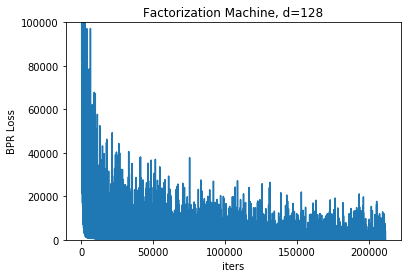

In [146]:
plt.title('Factorization Machine, d=128')
plt.xlabel('iters')
plt.ylabel('BPR Loss')
plt.ylim((0, 100000))
plt.plot(BPR_loss_hist)

In [148]:
torch.save(BPR_model, 'FM-d128-e20-BPR')

/home/carrot_go_round/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train model with TOP1 loss

In [149]:
TOP1_model = FM(d=128, session_dim=365, item_dim=158).to(device)

In [150]:
TOP1_optimizer = optim.Adagrad(TOP1_model.parameters())

In [151]:
train_loader = torch.utils.data.DataLoader(RecSys2019(), batch_size=64, shuffle=True, drop_last=True)

In [152]:
epochs = 20
print_every = 20

In [153]:
TOP1_loss_hist = []

In [155]:
for epoch in range(epochs):
        for batch_ind, (session_train, item_train, mask_train, y_train) in enumerate(train_loader):
            session_train, item_train, mask_train, y_train = session_train.to(device), item_train.to(device), mask_train.to(device), y_train.to(device)

            pred_train = TOP1_model(session_train.unsqueeze(1), item_train).squeeze(1)

            loss = TOP1loss(pred_train, pred_train[torch.arange(64), y_train.long()], y_train, mask_train)
            TOP1_loss_hist.append(loss.data)

            TOP1_optimizer.zero_grad()
            loss.backward()
            TOP1_optimizer.step()
            
            if batch_ind % print_every == 0:
                train_log = 'Epoch {:2d}/{:2d}\tLoss: {:.6f}\t\tTrain: [{}/{} ({:.0f}%)]      '.format(
                    epoch+1, epochs, loss.cpu().item(), batch_ind+1, len(train_loader), 100. * batch_ind / len(train_loader))
                print(train_log, end='\r')
                sys.stdout.flush()

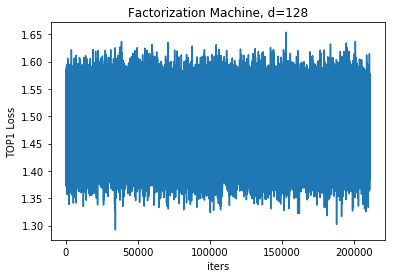

In [156]:
plt.title('Factorization Machine, d=128')
plt.xlabel('iters')
plt.ylabel('TOP1 Loss')
plt.plot(TOP1_loss_hist)

In [157]:
torch.save(TOP1_model, 'FM-d128-e20-TOP1')